In [1]:
import boto3
from botocore.client import Config
import pandas as pd
import json
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import *


In [2]:
# !pip install gspread
# !pip install pygsheets

In [3]:
from fonctions_s3 import *

ModuleNotFoundError: No module named 'fonctions_s3'

In [27]:
def initialize_buckets():
    with open('credentials.json') as mon_fichier:
        data = json.load(mon_fichier)


    AWS_ACCESS_KEY_ID = data["AWS_ACCESS_KEY_ID"]
    AWS_SECRET_ACCESS_KEY = data["AWS_SECRET_ACCESS_KEY"]
    AWS_REGION=data["AWS_REGION"]

    s3_resource = boto3.resource(
        's3',
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY
    )

    s3_client = boto3.client(
        's3',
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY
    )
    return s3_resource, s3_client




In [26]:

 with open('credentials.json') as mon_fichier:
    data = json.load(mon_fichier)


AWS_ACCESS_KEY_ID = data["AWS_ACCESS_KEY_ID"]
AWS_SECRET_ACCESS_KEY = data["AWS_SECRET_ACCESS_KEY"]
AWS_REGION=data["AWS_REGION"]

s3_resource = boto3.resource(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

s3_client = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY)


In [25]:
def load_file_from_bucket(bucket_name, file_name, type_marque ):
    s3_client = initialize_buckets()[1]
    obj = s3_client.get_object(Bucket= bucket_name, Key= file_name) 
    df = pd.read_csv(obj['Body'])
    df['type_marque'] = type_marque
    return df

In [ ]:
def upload_df_s3(df, nom_bucket, nom_fichier):
    bucket = nom_bucket
    csv_buffer = StringIO()
    df.to_csv(csv_buffer)
    s3_resource.Object(bucket, '{}.csv'.format(nom_fichier)).put(Body=csv_buffer.getvalue())
    return True


In [ ]:
#automatic uploading logic
bucket_name = 'csv-file-azatys-customers'  
 

try:
    # List objects in the S3 bucket
    objects = s3_client.list_objects(Bucket=bucket_name)

    # Initialize a list to store user names
    user_data = []
    order_data = []
    order_status_data = []
    reduction_data = []
    order_reduction_link_data = []
    for obj in objects.get('Contents', []):
        file_key = obj['Key']
        #print(file_key)

        # Check for keywords in the file key
        if 'user' in file_key:
            # Extract the username from the file key
            #username = file_key.split('_')[1]
            user_data.append(file_key)
        elif 'order' in file_key:
            order_data.append(file_key)
        elif 'order' in file_key:
            if 'statutes' in file_key:
                order_status_data.append(file_key)
            else:
                order_data.append(file_key)
                
        elif 'reductions' in file_key:
            reduction_data.append(file_key)
        elif 'reductions_link' in file_key:
            order_reduction_link_data.append(file_key)
            

    print("User Data:", user_data)
    #print(file_key)
    #print("Order Data:", order_data)
    #print("Order Status Data:", order_status_data)
    #print("Reduction Data:", reduction_data)
    #print("Order Reduction Link Data:", order_reduction_link_data)

   

except Exception as e:
    print(f"Error: {str(e)}")


## custom data 


In [9]:
# users data 

In [17]:
def load_all_customers(name):
    file_mapping = {
        "astickers": ("csv-file-azatys-customers", "444d60aD0c27c1FF51_astickers_users.csv", "astickers"),
        "mpadeco": ("csv-file-azatys-customers", "c8ad4d5E2C3369eCdA_mpadeco_users.csv", "mpadeco"),
        "mpapro": ("csv-file-azatys-customers", "0C93BeEb5dD1a5A2f9_mpapro_users.csv", "mpapro"),
        "plaques": ("csv-file-azatys-customers", "bBFDA29E0CfF67eb6c_plaques_users.csv", "plaques"),
    }

    if name in file_mapping:
        bucket, file_name, identifier = file_mapping[name]
        df_users = load_file_from_bucket(bucket, file_name, identifier)
        return df_users
    else:
        raise ValueError(f"Invalid name: {name}")

In [ ]:
# name_to_load = "mpapro_users"
# result = load_all_customers(name_to_load)

In [ ]:
# result["company"].unique()

In [18]:
def preprocess_user_data(df_users):
    if 'company' in df_users.columns:
        df_users['type_client'] = df_users['company'].fillna('particulier')
        df_users['type_client'] = df_users['type_client'].apply(lambda x: 'particulier' if x == 'particulier' else 'entreprise')
    else:
        df_users['type_client'] = 'particulier'  # Set a default value if 'company' column is not present

    df_users['date_created'] = pd.to_datetime(df_users['date_created'])
    df_users = df_users.loc[:, ['id', 'type_client', 'date_created', 'date_last_login', 'type_marque']]
    df_users = df_users.rename(columns={'id': 'id_user', 'date_created': 'date_acquisition',
                                        'date_last_login': 'date_recence_activite'})
    df_users['date_acquisition'] = pd.to_datetime(df_users['date_acquisition'])
    df_users['id_user'] = df_users['id_user'].astype(str)

    return df_users

In [ ]:
# orders 

In [19]:
def load_all_orders(name):
    file_mapping = {
        "astickers": ("csv-file-azatys-customers", "330C479A8Bfcaa3c91_astickers_orders.csv", "astickers"),
        "mpadeco": ("csv-file-azatys-customers", "6B47DEAee903aA6eCc_mpadeco_orders.csv", "mpadeco"),
        "mpapro": ("csv-file-azatys-customers", "DFBD08cc7F34eD4424_mpapro_orders.csv", "mpapro"),
        "plaques": ("csv-file-azatys-customers", "a1FCe93edAeBACEB5a_plaques_orders.csv", "plaques"),
    }

    if name in file_mapping:
        bucket, file_name, identifier = file_mapping[name]
        df_orders = load_file_from_bucket(bucket, file_name, identifier)
        return df_orders
    else:
        raise ValueError(f"Invalid name: {name}")

# Example usage:
#name_to_load_orders = "mpapro_orders"
#result_orders = load_all_orders(name_to_load_orders)
# Use 'result_orders' for further processing


In [20]:
def load_all_orders_statutes(name):
    file_mapping = {
        "astickers": ("csv-file-azatys-customers", "5A892ea3EC265D2Bb2_astickers_orders_statutes_link.csv", "astickers"),
        "mpadeco": ("csv-file-azatys-customers", "4AA8824D848dB14521_mpadeco_orders_statutes_link.csv", "mpadeco"),
        "mpapro": ("csv-file-azatys-customers", "fE20Fe4B6eE5DD8082_mpapro_orders_statutes_link.csv", "mpapro"),
        "plaques": ("csv-file-azatys-customers", "85b2D4dd56Eb80de17_plaques_orders_statutes_link.csv", "plaques"),
    }

    if name in file_mapping:
        bucket, file_name, identifier = file_mapping[name]
        df_orders_statutes = load_file_from_bucket(bucket, file_name, identifier)
        return df_orders_statutes
    else:
        raise ValueError(f"Invalid name: {name}")

# # Example usage:
# name_to_load_orders_statutes = "mpapro_orders_statutes"
# result_orders_statutes = load_all_orders_statutes(name_to_load_orders_statutes)
# # Use 'result_orders_statutes' for further processing


In [21]:
def load_all_reduction(name):
    file_mapping = {
        "astickers": ("csv-file-azatys-customers", "D22EEaed40B67ECDC7_astickers_reductions.csv", "astickers"),
        "mpadeco": ("csv-file-azatys-customers", "94Ffb63121F9c570Bf_mpadeco_reductions.csv", "mpadeco"),
        "mpapro": ("csv-file-azatys-customers", "6fb6AE8065c2BC9DDb_mpapro_reductions.csv", "mpapro"),
        "plaques": ("csv-file-azatys-customers", "AbEf2ebC308A3ac3c7_plaques_reductions.csv", "plaques"),
    }

    if name in file_mapping:
        bucket, file_name, identifier = file_mapping[name]
        df_reductions = load_file_from_bucket(bucket, file_name, identifier)
        return df_reductions
    else:
        raise ValueError(f"Invalid name: {name}")

# # Example usage:
# name_to_load_reductions = "mpapro_reductions"
# result_reductions = load_all_reduction(name_to_load_reductions)
# # Use 'result_reductions' for further processing


In [22]:
def load_all_order_reduction_link(name):
    file_mapping = {
        "astickers": ("csv-file-azatys-customers", "116ba4d23Be1CE6c5C_astickers_orders_reductions_link.csv", "astickers"),
        "mpadeco": ("csv-file-azatys-customers", "E3Ea85Be2abc3AC96C_mpadeco_orders_reductions_link.csv", "mpadeco"),
        "mpapro": ("csv-file-azatys-customers", "bD7fe9dcceB964a5B0_mpapro_orders_reductions_link.csv", "mpapro"),
        "plaques": ("csv-file-azatys-customers", "cb3d2ceCfaD9ad05Cb_plaques_orders_reductions_link.csv", "plaques"),
    }

    if name in file_mapping:
        bucket, file_name, identifier = file_mapping[name]
        df_orders_reductions = load_file_from_bucket(bucket, file_name, identifier)
        return df_orders_reductions
    else:
        raise ValueError(f"Invalid name: {name}")

# # Example usage:
# name_to_load_order_reduction_link = "mpapro_orders_reductions"
# result_order_reduction_link = load_all_order_reduction_link(name_to_load_order_reduction_link)
# # Use 'result_order_reduction_link' for further processing


In [23]:
def preprocess_orders_data(df_orders, df_orders_statutes, df_reductions, df_orders_reductions):
    df_orders_statutes = df_orders_statutes[df_orders_statutes['id_status'].isin([3, 4, 6, 7, 9, 10 ])]
    df_orders_statutes=df_orders_statutes.loc[:, ['type_marque', 'id_order']]
    df_orders_statutes.drop_duplicates(keep = 'first', inplace=True)
    df_orders = pd.merge(df_orders, df_orders_statutes, how="inner", left_on=['type_marque', 'id'],
                     right_on = ['type_marque', 'id_order'], validate="one_to_one")
    df_orders['date_created'] = pd.to_datetime(df_orders['date_created'])
    df_orders['date'] = pd.to_datetime(df_orders['date_created']).dt.date
    df_orders['annee'] = df_orders['date_created'].dt.year
    
    
    # reduction and order reduction link
    
    df_reductions=df_reductions.loc[:, ['id', 'type_marque','coupon_code', 'discount_amount', 'discount_type', 'active']]
    df_reductions=df_reductions.rename(columns={'id' : 'id_reduction', 'coupon_code' : 'code_reduction',
                                            'active' : 'reduction_actif'})
    df_orders_reductions = pd.merge(df_reductions, df_orders_reductions, how="right", left_on=['type_marque', 'id_reduction'],
                     right_on = ['type_marque', 'id_reduction'], validate="one_to_many")
    
    
    df_orders['reduc'] = np.where((df_orders.total_discount > 0) | (df_orders.total_loyalty > 0) |
                                   (df_orders.free_shipping > 0) , 1, 0)
    
    df_orders_reductions.drop(columns='id_user', inplace=True)
    df_orders = df_orders.loc[:, ['id_order', 'id_user', 'type_marque','total_items', 'total_taxes','total_discount', 'reduc',
                         'total_loyalty', 'free_shipping', 'total_shipping', 'total_order', 'date_created','date','annee']]
    
    df_orders = pd.merge(df_orders, df_orders_reductions, how="left", left_on=['type_marque', 'id_order'],
                     right_on = ['type_marque', 'id_order'], validate="one_to_one")
    


    return df_orders


In [4]:
# christell work update not using in it 
def enrich_custom_dash2(df_users, df_orders):
    df_users['id_user'] = df_users['id_user'].astype(str)
    df_orders['id_user'] = df_orders['id_user'].astype(str)  
    df_recence = df_orders.groupby(['type_marque','id_user']).agg(date_premier_achat=('date_created', 'min'),
                                                              date_dernier_achat=('date_created', 'max')).reset_index()
    
    df_users = pd.merge(df_users, df_recence, how="right", left_on=['type_marque', 'id_user'],
                     right_on = ['type_marque', 'id_user'], validate="one_to_one")
    df_users['date_recence_activite'] = np.where(df_users['date_recence_activite'] == '0000-00-00 00:00:00',\
                                              df_users['date_dernier_achat'], df_users['date_recence_activite'])
    df_users['date_recence_activite'] = pd.to_datetime(df_users['date_recence_activite'])
    df_orders = pd.merge(df_users, df_orders, how="right", left_on=['type_marque', 'id_user'],
                     right_on = ['type_marque', 'id_user'], validate="one_to_many") 
    
    df_orders['date_recence_activite'] = np.where(df_orders['date_recence_activite'] == '0000-00-00 00:00:00',\
                                              df_orders['date_dernier_achat'], df_orders['date_recence_activite'])
   
    df_orders['date_recence_activite'] = pd.to_datetime(df_orders['date_recence_activite'])
    
    df_orders['date'] = pd.to_datetime(df_orders['date'])
    df_orders['date_created'] = pd.to_datetime(df_orders['date_created'])
    df_orders['date_acquisition'] = pd.to_datetime(df_orders['date_acquisition'])
    df_orders['date_recence_activite'] = pd.to_datetime(df_orders['date_recence_activite'])
    
    

    return df_users,df_orders

In [21]:
# thsis one for cohort  table

In [5]:
#Cohort one 
def enrich_custom(df_users, df_orders):
    df_users['id_user'] = df_users['id_user'].astype(str)
    df_orders['id_user'] = df_orders['id_user'].astype(str)  
    df_recence = df_orders.groupby(['type_marque','id_user']).agg(date_premier_achat=('date_created', 'min'),
                                                              date_dernier_achat=('date_created', 'max')).reset_index()
    
    df_users = pd.merge(df_users, df_recence, how="right", left_on=['type_marque', 'id_user'],
                     right_on = ['type_marque', 'id_user'], validate="one_to_one")
   
    default_datetime = datetime(1970, 1, 1, 0, 0, 0)

    df_users['date_recence_activite'] = np.where(
        df_users['date_recence_activite'] == '0000-00-00 00:00:00', default_datetime, df_users['date_recence_activite'])
   # df_users['date_recence_activite'] = np.where(df_users['date_recence_activite'] == '0000-00-00 00:00:00',\
    #                                          df_users['date_dernier_achat'], df_users['date_recence_activite'])
    df_users['date_recence_activite'] = pd.to_datetime(df_users['date_recence_activite'])
    df_orders = pd.merge(df_users, df_orders, how="right", left_on=['type_marque', 'id_user'],
                     right_on = ['type_marque', 'id_user'], validate="one_to_many") 
    df_orders['date_recence_activite'] = df_orders['date_dernier_achat'] #order table last purchase
    # before this normaly we have cumml and annual
    df_orders = df_orders[df_orders['code_reduction'] != 'AREFAIRE']
    df_orders['id_order']=df_orders['type_marque'] + df_orders['id_order'].map(str) 
    df_orders['id_user'] = df_orders['id_user'].map(str) 
    df_orders['type_client'] = np.where((df_orders.type_client == 'entreprise') &
                                    (df_orders.type_marque.isin(['belleboite', 'coqfuneraire', 'mpadeco'])),
                                    'particulier', df_orders.type_client )
    df_orders['type_client'] = df_orders['type_client'].fillna('particulier')
    
    df_orders['month_year'] = df_orders['date_created'].dt.year.map(str) + df_orders['date_created'].dt.month.map(str).str.zfill(2)
    df_orders['isoweek_isoyear'] = df_orders['date_created'].dt.isocalendar().year.map(str) + \
    df_orders['date_created'].dt.isocalendar().week.map(str).str.zfill(2)
    
    df_orders['date'] = pd.to_datetime(df_orders['date']).dt.date
    df_orders['date_created'] = pd.to_datetime(df_orders['date_created']).dt.date
    df_orders['date_acquisition'] = pd.to_datetime(df_orders['date_acquisition']).dt.date
    df_orders['date_recence_activite'] = pd.to_datetime(df_orders['date_recence_activite']).dt.date
    df_orders['date_premier_achat'] = pd.to_datetime(df_orders['date_premier_achat']).dt.date
    df_orders['date_dernier_achat'] = pd.to_datetime(df_orders['date_dernier_achat']).dt.date
    df_orders['type_client'] = df_orders['type_client'].fillna('particulier')
   

    return df_users,df_orders

In [7]:
def get_users(name_to_load):

    df_users =load_all_customers(name_to_load)
    df_users_prerocced = preprocess_user_data(df_users)
    
    return df_users_prerocced

In [8]:
def get_orders(name_to_load):
    
    df_orders = load_all_orders(name_to_load)
    df_orders_statutes = load_all_orders_statutes(name_to_load)
    df_reductions = load_all_reduction(name_to_load) 
    df_orders_reductions = load_all_order_reduction_link(name_to_load) 
    df_orders = preprocess_orders_data(df_orders, df_orders_statutes, df_reductions, df_orders_reductions)
   
    return df_orders

In [9]:

# #only for custome data 
# name_to_load = "mpapro"
# users = get_users(name_to_load)
# orders = get_orders(name_to_load)
# users,orders = enrich_custom(users, orders)
# df_annuel, df_cumul = get_annual_cummu_dash2(orders, users)
# customer_cycle_de_vie, cohort_table = get_order_cohort_table(users,orders,df_cumul)

In [26]:
#customer_cycle_de_vie, cohort_table = get_order_cohort_table(shopify_users,shopify_orders,df_cumul)

## shopify data 

In [27]:
def load_all_shopify_customers(name):
    file_mapping = {
        "coqfuneraire": ("csv-file-azatys-customers", "39bB1dAFdcB0361B49_lecoqfuneraire_users.csv", "coqfuneraire"),
        "belleboite": ("csv-file-azatys-customers", "Db35DcedCDFfE9E8ab_mabelleboite_clients.csv", "belleboite"),
    }

    if name in file_mapping:
        bucket, file_name, identifier = file_mapping[name]
        df_shopify_users = load_file_from_bucket(bucket, file_name, identifier)
        return df_shopify_users
    else:
        raise ValueError(f"Invalid name: {name}")

# # Example usage:
# name_to_load_shopify_customers = "coqfuneraire_users"
# result_shopify_customers = load_all_shopify_customers(name_to_load_shopify_customers)
# # Use 'result_shopify_customers' for further processing


In [28]:
def preprocess_shopify_user_data(df_shopify_users):
    df_shopify_users['id'] =  np.where((df_shopify_users['Email'].isna()), df_shopify_users['Last Name']+df_shopify_users['First Name'], df_shopify_users['Email'])
    df_shopify_users['id'] = df_shopify_users['id'].str.lower()
    df_shopify_users['type_client'] = df_shopify_users['Company'].fillna('particulier')
    df_shopify_users['type_client'] = df_shopify_users['type_client'].apply(lambda x: 'particulier' if x == 'particulier' else 'entreprise')
    df_shopify_users=df_shopify_users.loc[:, ['id', 'type_client', 'type_marque']]
    df_shopify_users=df_shopify_users.rename(columns={'id' : 'id_user'})
    
    return df_shopify_users


In [29]:
## shopify order 


In [30]:
def load_all_shopify_orders(name):
    file_mapping = {
        "coqfuneraire": ("csv-file-azatys-customers", "9031D8355AECFeC7Ca_lecoqfuneraire_orders.csv", "coqfuneraire"),
        "belleboite": ("csv-file-azatys-customers", "9eAAecB4Db2f40cB03_mabelleboite_commandes.csv", "belleboite"),
    }

    if name in file_mapping:
        bucket, file_name, identifier = file_mapping[name]
        df_shopify_orders = load_file_from_bucket(bucket, file_name, identifier)
        return df_shopify_orders
    else:
        raise ValueError(f"Invalid name: {name}")

# # Example usage:
# name_to_load_shopify_orders = "coqfuneraire_orders"
# result_shopify_orders = load_all_shopify_orders(name_to_load_shopify_orders)
# # Use 'result_shopify_orders' for further processing


In [31]:
def load_all_shopify_reduction(name):
    file_mapping = {
        "coqfuneraire": ("csv-file-azatys-customers", "a8cae4Aab4C3D75d8E_lecoqfuneraire_reductions.csv", "coqfuneraire"),
        "belleboite": ("csv-file-azatys-customers", "86Ed2fd3E1EBD5A81d_mabelleboite_reductions.csv", "belleboite"),
    }

    if name in file_mapping:
        bucket, file_name, identifier = file_mapping[name]
        df_shopify_reductions = load_file_from_bucket(bucket, file_name, identifier)
        return df_shopify_reductions
    else:
        raise ValueError(f"Invalid name: {name}")

# # Example usage:
# name_to_load_shopify_reduction = "coqfuneraire_reductions"
# result_shopify_reduction = load_all_shopify_reduction(name_to_load_shopify_reduction)
# # Use 'result_shopify_reduction' for further processing


In [32]:
def preprocess_shopify_orders_data(df_shopify_orders, df_shopify_reductions):
    df_shopify_orders = df_shopify_orders[df_shopify_orders['Financial Status'].isin(['paid', 'partially_refunded'])]
    df_shopify_orders['Refunded Amount'] = np.where(df_shopify_orders['Financial Status']=='partially_refunded', df_shopify_orders['Refunded Amount'], 0)
    df_shopify_orders['total_order'] = df_shopify_orders['Total'].astype(float) - df_shopify_orders['Refunded Amount'].astype(float)   
    df_shopify_orders['total_taxes'] = df_shopify_orders['Taxes'].astype(float) -\
    (df_shopify_orders['Refunded Amount'].astype(float)*(df_shopify_orders['Taxes'].astype(float)/df_shopify_orders['Total'].astype(float)))
    df_shopify_orders['total_items'] = df_shopify_orders['total_order'].astype(float) - df_shopify_orders['total_taxes'].astype(float) -\
    df_shopify_orders['Shipping'].astype(float)
    df_shopify_orders['id_user'] = np.where((df_shopify_orders['Email'].isna()), df_shopify_orders['Billing Name'], df_shopify_orders['Email'])
    df_shopify_orders['id_user'] = df_shopify_orders['id_user'].str.lower()
    df_shopify_orders['date_created'] = pd.to_datetime(df_shopify_orders['Created at'], utc=True)
    df_shopify_orders['date'] = pd.to_datetime(df_shopify_orders['date_created'], utc=True).dt.date
    df_shopify_orders['annee'] = df_shopify_orders['date_created'].dt.year
    df_shopify_orders['free_shipping'] = np.where((df_shopify_orders['Shipping'] == 0), 1, 0)
    df_shopify_orders['total_loyalty'] = 0
    df_shopify_orders=df_shopify_orders.rename(columns={'Name' : 'id_order', 'Shipping' : 'total_shipping', 'Discount Amount' : 'total_discount',
                                   'Discount Code' : 'code_reduction'})
    df_shopify_orders['reduc'] = np.where((df_shopify_orders.total_discount > 0) | (df_shopify_orders.total_loyalty > 0) |
                                   (df_shopify_orders.free_shipping > 0) , 1, 0)
    df_shopify_orders = df_shopify_orders.loc[:, ['id_order', 'id_user', 'type_marque','total_items', 'total_taxes','total_discount', 'reduc',
                              'total_loyalty', 'free_shipping', 'total_shipping', 'total_order', 'date_created','date','annee',
                              'code_reduction']]
    
    #reduction 
    df_shopify_reductions['reduction_actif'] = np.where(df_shopify_reductions.Status == 'Active' , 1, 0)
    df_shopify_reductions['discount_type'] = np.where(df_shopify_reductions['Value Type'] == 'percentage' , 'relative', 'fixed')
    df_shopify_reductions=df_shopify_reductions.rename(columns={'Name' : 'code_reduction', 'Value' : 'discount_amount'})
    df_shopify_reductions=df_shopify_reductions.loc[:, ['type_marque','code_reduction', 'discount_amount', 'discount_type', 'reduction_actif']]
    
    #merge of reduction and order 
    
    df_shopify_orders = pd.merge(df_shopify_orders, df_shopify_reductions, how="left", left_on=['type_marque', 'code_reduction'],
                     right_on = ['type_marque', 'code_reduction'], validate="many_to_one")
    
    
    
    
    
    



    return df_shopify_orders


In [33]:
def enrich(df_users, df_shopify_orders):
    df_acquis = df_shopify_orders.groupby(['type_marque','id_user']).agg(date_acquisition=('date_created', 'min')).reset_index()
    df_users = pd.merge(df_users, df_acquis, how="right", left_on=['type_marque', 'id_user'],
                     right_on = ['type_marque', 'id_user'], validate="one_to_one")
    df_recence = df_shopify_orders.groupby(['type_marque','id_user']).agg(date_premier_achat=('date_created', 'min'),
                                                              date_dernier_achat=('date_created', 'max')).reset_index()
    df_users = pd.merge(df_users, df_recence, how="right", left_on=['type_marque', 'id_user'],
                     right_on = ['type_marque', 'id_user'], validate="one_to_one")
    df_users['date_recence_activite'] = df_users['date_dernier_achat']
    df_shopify_orders = pd.merge(df_users, df_shopify_orders, how="right", left_on=['type_marque', 'id_user'],
                     right_on = ['type_marque', 'id_user'], validate="one_to_many")
    df_shopify_orders['date_recence_activite'] = df_shopify_orders['date_dernier_achat']
    
    #normaly we get cumul and annual until here 
    
    df_shopify_orders = df_shopify_orders[df_shopify_orders['code_reduction'] != 'AREFAIRE']
    df_shopify_orders['id_order']=df_shopify_orders['type_marque'] + df_shopify_orders['id_order'].map(str) 
    df_shopify_orders['id_user'] = df_shopify_orders['id_user'].map(str) 
    df_shopify_orders['type_client'] = np.where((df_shopify_orders.type_client == 'entreprise') &
                                    (df_shopify_orders.type_marque.isin(['belleboite', 'coqfuneraire', 'mpadeco'])),
                                    'particulier', df_shopify_orders.type_client )
    df_shopify_orders['type_client'] = df_shopify_orders['type_client'].fillna('particulier')
    
    df_shopify_orders['month_year'] = df_shopify_orders['date_created'].dt.year.map(str) + df_shopify_orders['date_created'].dt.month.map(str).str.zfill(2)
    df_shopify_orders['isoweek_isoyear'] = df_shopify_orders['date_created'].dt.isocalendar().year.map(str) + \
    df_shopify_orders['date_created'].dt.isocalendar().week.map(str).str.zfill(2)
    
    df_shopify_orders['date'] = pd.to_datetime(df_shopify_orders['date']).dt.date
    df_shopify_orders['date_created'] = pd.to_datetime(df_shopify_orders['date_created']).dt.date
    df_shopify_orders['date_acquisition'] = pd.to_datetime(df_shopify_orders['date_acquisition']).dt.date
    df_shopify_orders['date_recence_activite'] = pd.to_datetime(df_shopify_orders['date_recence_activite']).dt.date
    df_shopify_orders['date_premier_achat'] = pd.to_datetime(df_shopify_orders['date_premier_achat']).dt.date
    df_shopify_orders['date_dernier_achat'] = pd.to_datetime(df_shopify_orders['date_dernier_achat']).dt.date
    df_shopify_orders['type_client'] = df_shopify_orders['type_client'].fillna('particulier')
    
    return df_users,df_shopify_orders, 

## calling shopify and custome

In [34]:
  

def get_shopify_users(name_to_load):
    #name_to_load = "belleboite"
    df_shopify_users = load_all_shopify_customers(name_to_load)
    df_shopify_users_prerocced = preprocess_shopify_user_data(df_shopify_users)
    
    return df_shopify_users_prerocced
    

In [26]:
def get_shopify_orders(name_to_load):
    #name_to_load = "belleboite"
    df_shopify_orders = load_all_shopify_orders(name_to_load)
    df_shopify_reductions = load_all_shopify_reduction(name_to_load)  
    df_shopify_orders = preprocess_shopify_orders_data(df_shopify_orders, df_shopify_reductions)
   
   
    return df_shopify_orders
    

In [27]:
name_to_load = "belleboite"
shopify_users = get_shopify_users(name_to_load)
shopify_orders = get_shopify_orders(name_to_load)
shopify_users,shopify_orders = enrich(shopify_users, shopify_orders)

df_annuel, df_cumul = get_annual_cummu_dash2(shopify_orders, shopify_users)


NameError: name 'load_all_shopify_customers' is not defined

## for all users and orders concat of custome and shopify 

In [ ]:
#for all the custome and shopify 
users = get_users()
orders = get_orders()
users,orders = enrich_custom(users, orders)
shopify_users = get_shopify_users()
shopify_orders = get_shopify_orders()
shopify_users,shopify_orders = enrich(shopify_users, shopify_orders)
shopify_users = pd.concat([users, shopify_users])
shopify_orders = pd.concat([orders, shopify_orders])

#pdf_orders_users = get_merged(shopify_users, shopify_orders)
#df_annuel_cohort, df_cumul_cohort = get_annual_cummul(pdf_orders_users)

df_annuel, df_cumul = get_annual_cummu_dash2(shopify_orders, shopify_users)
customer_cycle_de_vie, cohort_table = get_order_cohort_table(shopify_users,shopify_orders,df_cumul)

# common Trabsform function 

In [10]:
def get_merged(shopify_users, shopify_orders):
    pdf_orders_users = pd.merge(shopify_users, shopify_orders, how="right", left_on=['type_marque', 'id_user'],
                            right_on=['type_marque', 'id_user'], validate="one_to_many") 
    pdf_orders_users = pdf_orders_users.drop(['type_client_x', 'date_acquisition_x', 'date_premier_achat_x', 'date_dernier_achat_x', 'date_recence_activite_x'], axis=1)
    pdf_orders_users=pdf_orders_users.rename(columns={"type_client_y": "type_client", "date_acquisition_y": "date_acquisition", "date_premier_achat_y" : "date_premier_achat", "date_dernier_achat_y" : "date_dernier_achat", "date_recence_activite_y" : "date_recence_activite" })
    pdf_orders_users['type_marque_client'] = pdf_orders_users['type_marque'] + '-' + pdf_orders_users['type_client']
    
    return pdf_orders_users
    

In [11]:

def get_annual_cummu_dash2(df_orders, df_users):
    df_orders['date_created'] = pd.to_datetime(df_orders['date_created'])  # Ensure 'date_created' column is in datetime format
    
    df_orders['type_marque_client'] = df_orders['type_marque'] + '-' + df_orders['type_client']
    
    df_annuel = df_orders[df_orders['date_created'] < '2022-05-30 00:00:00'].\
        groupby(['annee', 'type_marque', 'id_user', 'type_client', 'date_acquisition', 'date_recence_activite']).agg(
            ca=('total_order', 'sum'), NBJ=('date', 'nunique'), date_premier_achat=('date_created', 'min'),
            date_dernier_achat=('date_created', 'max'),
            ca_produit=('total_items', 'sum'), total_discount=('total_discount', 'sum'), total_loyalty=('total_loyalty', 'sum'),
            free_shipping=('free_shipping', 'sum'), total_shipping=('total_shipping', 'sum'), nb_commande=('id_order', 'count'),
            nb_commande_reduc=('reduc', 'sum'),
            date_created=('date_created', 'first'),  # Include 'date_created' column
            order_date = ('date', 'first'),
            type_marque_client = ('type_marque_client', 'first')).reset_index()

    df_annuel['client_reduc'] = np.where((df_annuel.nb_commande_reduc > 0) | (df_annuel.nb_commande_reduc > 0) |
                                        (df_annuel.nb_commande_reduc > 0), 1, 0)
    
    df_annuel['RFM'] = np.where(df_annuel['NBJ'] >= 4, '4Jrs et +',
                                     np.where(df_annuel['NBJ'] >= 2, '2 et 3Jrs',
                                              np.where(df_annuel['ca'] >= 50, '1Jr / 50€ et +',
                                                       np.where(df_annuel['ca'] >= 25, '1Jr / 25-49€', '1Jr / 1-024€'))))    
        
    df_annuel['date_recence_activite'] = pd.to_datetime(df_annuel['date_recence_activite'])
    df_annuel['date_created'] = pd.to_datetime(df_annuel['date_created'])    
    df_annuel['month_differences']= (df_annuel['date_recence_activite'] - df_annuel['date_created']) / np.timedelta64(1, 'M')
    df_annuel['month_differences'] = df_annuel['month_differences'].astype(int)
    
    
    
    df_annuel['RFM_comande'] = np.where(df_annuel['nb_commande'] >= 2, '2 achat et +',
                                         np.where(df_annuel['nb_commande'] == 1,
                                                  np.where(df_annuel['ca'] >= 50,
                                                           np.where(df_annuel['month_differences'] < 6, 
                                                                    '1 achat 50€ et + / création <6moins',
                                                                    '1 achat / 50€+'
                                                                   ),
                                                           np.where(df_annuel['ca'] < 50,
                                                                    np.where(df_annuel['month_differences'] < 6,
                                                                             '1 achat 1-49€ / création <6moins',
                                                                             '1 achat / 1-49€'
                                                                            ),
                                                                    'non'
                                                                   )
                                                          ),
                                                  'non'
                                                 )
                                        )
     # created and dernierachat
#     condition_1 = (df_annuel['nb_commande'] == 1) & (df_annuel['ca'] >= 50)
#     condition_2 = (df_annuel['nb_commande'] == 1) & (df_annuel['ca'] < 50)
#     condition_3 = (df_annuel['nb_commande'] >= 2)
#     condition_4 = (df_annuel['nb_commande'] == 1) & (df_annuel['ca'] >= 50) & (df_annuel['month_differences'] < 6)
#     condition_5 = (df_annuel['nb_commande'] == 1) & (df_annuel['ca'] < 50) & (df_annuel['month_differences'] < 6)

#     df_annuel['RFM_command'] = np.select(
#         [condition_4, condition_5, condition_1, condition_2, condition_3],
#         ['1achat / 50€ et + - Less than 6 months',
#          '1achat / 1-49€ - Less than 6 months',
#          '1achat / 50€+',
#          '1achat / 1-49€',
#          '2achat et +'],
#         default=np.nan
#     )

    df_annuel['date_acquisition'] = pd.to_datetime(df_annuel['date_acquisition'])
    df_annuel['ANCIENNETE'] = df_annuel['annee'] - df_annuel['date_acquisition'].dt.year
    df_annuel['ANCIENNETE'] = np.where(df_annuel['ANCIENNETE'] > 5, '5 et +', df_annuel['ANCIENNETE'])
    df_annuel['ANCIENNETE_cat'] = df_annuel['annee'] - df_annuel['date_acquisition'].dt.year
    df_annuel['ANCIENNETE_cat'] = np.where(df_annuel['ANCIENNETE'] == 0, 'nouveau', 'ancienn')
    df_annuel['ca_moyen'] = df_annuel['ca'] / df_annuel['NBJ']
    df_annuel['NBJ_GRP'] = np.where(df_annuel['NBJ'] > 3, '4 et +', np.where(df_annuel['NBJ'] > 1, '2-3', '1'))
    df_annuel['ca_moyen_GRP'] = np.where(df_annuel['ca_moyen'] >= 50, '50 et +',
                                         np.where(df_annuel['ca_moyen'] >= 25, '25-49', '1-24'))
    
    

    df_cumul = df_annuel[df_annuel['annee'] > 2016].\
        groupby(['type_marque_client','type_marque', 'id_user', 'type_client', 'date_acquisition', 'date_recence_activite']).agg(
            ca=('ca', 'sum'), NBJ=('NBJ', 'sum'), date_premier_achat=('date_premier_achat', 'min'),
            date_dernier_achat=('date_dernier_achat', 'max'),
            ca_produit=('ca_produit', 'sum'), total_discount=('total_discount', 'sum'), total_loyalty=('total_loyalty', 'sum'),
            free_shipping=('free_shipping', 'sum'), total_shipping=('total_shipping', 'sum'), nb_commande=('nb_commande', 'sum'),
            nb_commande_reduc=('nb_commande_reduc', 'sum'),
            order_date=('date_created', 'first'),
            #order_date = ('order_date', 'first'),# Include column
            RFM = ('RFM', 'first'),
            RFM_comande = ('RFM_comande', 'first')

            ).reset_index()

    df_cumul['client_reduc'] = np.where((df_cumul.nb_commande_reduc > 0) | (df_cumul.nb_commande_reduc > 0) |
                                        (df_cumul.nb_commande_reduc > 0), 1, 0)

    df_cumul['date_dernier_achat'] = pd.to_datetime(df_cumul['date_dernier_achat'])
    df_cumul['date_premier_achat'] = pd.to_datetime(df_cumul['date_premier_achat'])
    df_cumul['date_acquisition'] = pd.to_datetime(df_cumul['date_acquisition'])

    df_cumul['delai_achat'] = (
    (df_cumul['date_dernier_achat'] - df_cumul['date_premier_achat']) / (df_cumul['NBJ'] - 1)
        ).apply(lambda x: np.ceil(x.days))

    df_cumul['RECENCE'] = 12 * (2022 - df_cumul['date_dernier_achat'].dt.year) + (5 - df_cumul['date_dernier_achat'].dt.month)
    df_cumul['ANCIENNETE'] = (df_cumul['date_premier_achat'].dt.to_period('M').astype('int64') -
                              df_cumul['date_acquisition'].dt.to_period('M').astype('int64'))
    

    df_cumul['ANCIENNETE'] = np.where((df_cumul['ANCIENNETE'] > 1), 'M2 et +', 'M' + df_cumul['ANCIENNETE'].astype('string'))

    df_cumul['ANCIENNETE'] = np.where(
        (df_cumul['ANCIENNETE'] == 'M0') &
        (pd.to_datetime(df_cumul['date_premier_achat']).dt.date == pd.to_datetime(df_cumul['date_acquisition']).dt.date),
        'J0', df_cumul['ANCIENNETE']
    )
    
    df_cumul['date_recence_activite'] = pd.to_datetime(df_annuel['date_recence_activite'])
    
    df_cumul['date_dernier_achat'] = pd.to_datetime(df_annuel['date_dernier_achat'])
    
    df_cumul['delai_last_login_JR'] = (
        pd.to_datetime(df_cumul['date_recence_activite']).dt.to_period('D').astype('int64') -
        pd.to_datetime(df_cumul['date_dernier_achat']).dt.to_period('D').astype('int64')
    )

    df_cumul['delai_last_login'] = (
        df_cumul['date_recence_activite'].dt.to_period('M').astype('int64') -
        df_cumul['date_dernier_achat'].dt.to_period('M').astype('int64')
    )

    df_cumul['delai_last_login_tr'] = np.where((df_cumul['delai_last_login'] >= 18), '18 et +', df_cumul['delai_last_login'])
    df_cumul['delai_last_login_tr'] = df_cumul['delai_last_login_tr'].apply(lambda x: x.zfill(2))
    df_cumul['delai_last_login_tr'] = np.where(
        (df_cumul['delai_last_login'] == 0) & (df_cumul['delai_last_login_JR'] <= 7), 'S0', df_cumul['delai_last_login_tr']
    )
    df_cumul['delai_last_login_tr'] = np.where(
        (df_cumul['delai_last_login'] == 0) & (df_cumul['delai_last_login_JR'] == 0), 'J0', df_cumul['delai_last_login_tr']
    )
    


    

    return df_annuel, df_cumul


In [12]:
# # for now we are not using 
# def get_annual_cummul(pdf_orders_users):
#     df_annuel = pdf_orders_users.groupby(['annee', 'type_marque', 'id_user', 'type_client', 'date_acquisition']).agg(
#     #ca is sum of total orders 
#     ca=('total_order', 'sum'), NBJ=('date', 'nunique'),
#     date_premier_achat=('date_created', 'min'), date_dernier_achat=('date_created', 'max'),
#     ca_produit=('total_items', 'sum'), total_discount=('total_discount', 'sum'),
#     total_loyalty=('total_loyalty', 'sum'), free_shipping=('free_shipping', 'sum'),
#     total_shipping=('total_shipping', 'sum'), nb_commande=('id_order', 'count'),
#     nb_commande_reduc=('reduc', 'sum'),
#     date_created=('date_created', 'first'),  # Include 'date_created' column
#     order_date = ('date', 'first'),
#     type_marque_client = ('type_marque_client', 'first')
#     ).reset_index()
    
#     df_annuel['annee'] = pd.to_datetime(df_annuel['annee'])
#     df_annuel['date_acquisition'] = pd.to_datetime(df_annuel['date_acquisition'])
#     df_annuel['annee'] = df_annuel['annee'].dt.year
#     df_annuel['ANCIENNETE'] = df_annuel['annee'] - df_annuel['date_acquisition'].dt.year
#     df_annuel['ANCIENNETE'] = np.where(df_annuel['ANCIENNETE'] > 5, '5 et +', df_annuel['ANCIENNETE'])
#     df_annuel['ANCIENNETE_cat'] = df_annuel['annee'] - df_annuel['date_acquisition'].dt.year
#     df_annuel['ANCIENNETE_cat'] = np.where(df_annuel['ANCIENNETE'] == 0, 'nouveau', 'ancienn')
#     df_annuel['ca_moyen'] = df_annuel['ca'] / df_annuel['NBJ']
#     df_annuel['NBJ_GRP'] = np.where(df_annuel['NBJ'] > 3, '4 et +', np.where(df_annuel['NBJ'] > 1, '2-3', '1'))
#     df_annuel['ca_moyen_GRP'] = np.where(df_annuel['ca_moyen'] >= 50, '50 et +',
#                                      np.where(df_annuel['ca_moyen'] >= 25, '25-49', '1-24'))
#     df_annuel['RFM'] = np.where(df_annuel['NBJ'] >= 4, '4Jrs et +',
#                                      np.where(df_annuel['NBJ'] >= 2, '2 et 3Jrs',
#                                               np.where(df_annuel['ca'] >= 50, '1Jr / 50€ et +',
#                                                        np.where(df_annuel['ca'] >= 25, '1Jr / 25-49€', '1Jr / 1-024€'))))
    
#     df_cumul = df_annuel.groupby(['type_marque_client','id_user', 'type_client', 'date_acquisition']).agg(
#     ca=('ca', 'sum'), NBJ=('NBJ', 'sum'), date_premier_achat=('date_premier_achat', 'min'),
#     date_dernier_achat=('date_dernier_achat', 'max'),
#     ca_produit=('ca_produit', 'sum'), total_discount=('total_discount', 'sum'),
#     total_loyalty=('total_loyalty', 'sum'), free_shipping=('free_shipping', 'sum'),
#     total_shipping=('total_shipping', 'sum'), nb_commande=('nb_commande', 'sum'),
#     nb_commande_reduc=('nb_commande_reduc', 'sum'),
#     order_date=('date_created', 'first'),
#     #order_date = ('order_date', 'first'),# Include column
#     RFM = ('RFM', 'first'),
#     RFM_comande = ('RFM_comande', 'first')
#     ).reset_index()
    
#     return df_annuel,df_cumul

    
    

    

In [13]:
def categorize_cycle_cumul(nb_commande):
    if nb_commande == 1:
        return 'one'
    elif nb_commande == -1:
        return 'sans achat'
    else:
        if nb_commande == 2:
            return '2 achat'
        elif nb_commande == 3:
            return '3 achat'
        elif 4 <= nb_commande <= 5:
            return '4et5 achat'
        elif nb_commande < 6:
            return '6 achat et Plus'

In [14]:
def categorize_cycle(nb_commande):
    if nb_commande == 1:
        return 'one'
    elif nb_commande == -1:
        return 'sans achat'
    else:
        return 'multiple'

# Apply the function to create the 'cycle_de_vie' column
#df_order_user3['cycle_de_vie'] = df_order_user3['nb_commande'].apply(categorize_cycle)


In [15]:
def get_order_cohort_table(shopify_users, shopify_orders, df_cumul):
    df = pd.merge(shopify_users, shopify_orders, on='id_user', how='left')
    udf_users = df[['id_user', 'date_acquisition_x']]
    #udf_users = df['id_user'].unique()
    udf_users = pd.DataFrame(udf_users)
    sans_acaht_table_cuml = pd.merge(udf_users, df_cumul, on='id_user', how='left') # account  created not buy
    df_order_user1 = sans_acaht_table_cuml
    df_order_user1['date_acquisition_x'] = pd.to_datetime(df_order_user1['date_acquisition_x'], utc=True)
    df_order_user1['date_acquisition_x'] = df_order_user1['date_acquisition_x'].dt.strftime('%Y-%m-%d')
    df_order_user1['nb_commande'].fillna(-1, inplace = True)
    df_order_user1['cycle_de_vie'] = df_order_user1['nb_commande'].apply(categorize_cycle)
    df_order_user1['date_dernier_achat'] = df_order_user1.apply(lambda row: row['date_acquisition_x'] if pd.isnull(row['date_dernier_achat']) else row['date_dernier_achat'], axis=1)
    #df_order_user1['date_dernier_achat'] = pd.to_datetime(df_order_user1['date_dernier_achat'])
    df_order_user1['RFM'].fillna('no', inplace = True)
    df_order_user1['RFM_comande'].fillna('no', inplace = True)
    df_order_user1['type_marque_client'].fillna('no', inplace = True)
    
    cohort_tablecmd = df_order_user1.groupby(['cycle_de_vie', 'RFM', 'type_marque_client']).agg({
    'id_user': 'nunique',
    'nb_commande': 'sum',
    'ca_produit' : 'nunique',
    'ca': 'sum',
    }).reset_index()
    
    
    cohort_table = df_order_user1.groupby(['date_dernier_achat', 'cycle_de_vie', 'RFM', 'type_marque_client']).agg({
    'id_user': 'nunique',
    'nb_commande': 'sum',
    'ca_produit' : 'nunique',
    'ca': 'sum',
    }).reset_index()
    
    df_order_user = sans_acaht_table_cuml
    customer_cycle_de_vie = df_order_user.groupby(['order_date', 'cycle_de_vie','RFM', 'type_marque_client']).agg({
    'id_user': 'nunique',
    'nb_commande': 'sum',
    'ca_produit' : 'nunique',
    'ca': 'sum',
    }).reset_index()
    
    prism = df_order_user1.groupby(['date_dernier_achat', 'cycle_de_vie', 'RFM_comande', 'type_marque_client']).agg({
    'ca': 'sum',
    'id_user': 'count',}).reset_index()
    

    
    return customer_cycle_de_vie, cohort_table, cohort_tablecmd, prism 



    

    

In [28]:

#only for custome data 
name_to_load = "mpapro"
users = get_users(name_to_load)
orders = get_orders(name_to_load)
users,orders = enrich_custom(users, orders)
df_annuel, df_cumul = get_annual_cummu_dash2(orders, users)
#df_cumul['cycle_de_vie'] = df_cumul['nb_commande'].apply(categorize_cycle_cumul)
customer_cycle_de_vie, cohort_table, cohort_tablecmd, prism  = get_order_cohort_table(users,orders,df_cumul)

C:\Users\kaust\AppData\Local\Temp\ipykernel_19780\2199510175.py:26: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  cohort_table = df_order_user1.groupby(['date_dernier_achat', 'cycle_de_vie', 'RFM', 'type_marque_client']).agg({
C:\Users\kaust\AppData\Local\Temp\ipykernel_19780\2199510175.py:41: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  prism = df_order_user1.groupby(['date_dernier_achat', 'cycle_de_vie', 'RFM_comande', 'type_marque_client']).agg({


In [43]:
df_cumul

,type_marque_client,type_marque,id_user,type_client,date_acquisition,date_recence_activite,ca,NBJ,date_premier_achat,date_dernier_achat,...,order_date,RFM,RFM_comande,client_reduc,delai_achat,RECENCE,ANCIENNETE,delai_last_login_JR,delai_last_login,delai_last_login_tr
0,mpapro-entreprise,mpapro,100199,entreprise,2013-09-12,2012-04-17,862.04,4,2019-12-01,2012-04-17,...,2019-12-01,1Jr / 50€ et +,1 achat / 50€+,1,235.0,6,M2 et +,0,0,J0
1,mpapro-entreprise,mpapro,100361,entreprise,2013-09-25,2012-04-18,149.90,1,2021-06-16,2012-04-18,...,2021-06-16,1Jr / 50€ et +,1 achat 50€ et + / création <6moins,1,NaN,11,M2 et +,0,0,J0
2,mpapro-entreprise,mpapro,100440,entreprise,2013-10-01,2012-04-17,87.50,1,2017-10-17,2012-04-17,...,2017-10-17,1Jr / 50€ et +,1 achat 50€ et + / création <6moins,0,NaN,55,M2 et +,0,0,J0
3,mpapro-entreprise,mpapro,100676,entreprise,2013-10-20,2012-04-17,230.84,1,2020-11-20,2012-04-17,...,2020-11-20,1Jr / 50€ et +,1 achat 50€ et + / création <6moins,1,NaN,18,M2 et +,0,0,J0
4,mpapro-entreprise,mpapro,100750,entreprise,2013-10-27,2012-04-18,27.77,1,2022-02-19,2012-04-18,...,2022-02-19,1Jr / 25-49€,1 achat 1-49€ / création <6moins,1,NaN,3,M2 et +,0,0,J0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123214,mpapro-particulier,mpapro,99862,particulier,2013-08-17,2021-05-10,2820.53,11,2017-12-10,2021-05-10,...,2017-12-10,1Jr / 50€ et +,1 achat / 50€+,1,162.0,0,M2 et +,0,0,J0
123215,mpapro-particulier,mpapro,99870,particulier,2013-08-18,2021-05-10,91.42,1,2018-10-26,2021-05-10,...,2018-10-26,1Jr / 50€ et +,1 achat 50€ et + / création <6moins,0,NaN,43,M2 et +,0,0,J0
123216,mpapro-particulier,mpapro,99909,particulier,2013-08-21,2021-05-10,23.29,2,2018-11-30,2021-05-10,...,2018-11-30,1Jr / 1-024€,1 achat / 1-49€,1,1094.0,6,M2 et +,0,0,J0
123217,mpapro-particulier,mpapro,99931,particulier,2013-08-23,2021-05-10,1174.93,17,2017-01-25,2021-05-10,...,2017-01-25,4Jrs et +,2 achat et +,1,110.0,6,M2 et +,0,0,J0


In [29]:
df2021 = df_cumul[df_cumul['date_dernier_achat'].dt.year == 2021]


In [30]:
df2021

,type_marque_client,type_marque,id_user,type_client,date_acquisition,date_recence_activite,ca,NBJ,date_premier_achat,date_dernier_achat,...,order_date,RFM,RFM_comande,client_reduc,delai_achat,RECENCE,ANCIENNETE,delai_last_login_JR,delai_last_login,delai_last_login_tr
102801,mpapro-particulier,mpapro,266101,particulier,2021-09-04,2021-09-11,23.00,1,2021-09-04,2021-09-11,...,2021-09-04,1Jr / 1-024€,1 achat 1-49€ / création <6moins,0,NaN,8,J0,0,0,J0
102802,mpapro-particulier,mpapro,266102,particulier,2021-09-04,2022-06-29,16.40,1,2021-09-04,2021-05-14,...,2021-09-04,1Jr / 1-024€,1 achat 1-49€ / création <6moins,0,NaN,8,J0,411,13,13
102803,mpapro-particulier,mpapro,266103,particulier,2021-09-04,2022-03-18,69.80,2,2021-09-04,2021-10-14,...,2021-09-04,1Jr / 25-49€,1 achat / 1-49€,0,194.0,2,J0,155,5,05
102804,mpapro-particulier,mpapro,266104,particulier,2021-09-04,2021-11-05,18.58,1,2021-09-04,2021-11-05,...,2021-09-04,1Jr / 1-024€,1 achat 1-49€ / création <6moins,0,NaN,8,J0,0,0,J0
102805,mpapro-particulier,mpapro,266105,particulier,2021-09-04,2021-02-24,9.15,1,2021-09-04,2021-02-24,...,2021-09-04,1Jr / 1-024€,1 achat 1-49€ / création <6moins,0,NaN,8,J0,0,0,J0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123214,mpapro-particulier,mpapro,99862,particulier,2013-08-17,2021-05-10,2820.53,11,2017-12-10,2021-05-10,...,2017-12-10,1Jr / 50€ et +,1 achat / 50€+,1,162.0,0,M2 et +,0,0,J0
123215,mpapro-particulier,mpapro,99870,particulier,2013-08-18,2021-05-10,91.42,1,2018-10-26,2021-05-10,...,2018-10-26,1Jr / 50€ et +,1 achat 50€ et + / création <6moins,0,NaN,43,M2 et +,0,0,J0
123216,mpapro-particulier,mpapro,99909,particulier,2013-08-21,2021-05-10,23.29,2,2018-11-30,2021-05-10,...,2018-11-30,1Jr / 1-024€,1 achat / 1-49€,1,1094.0,6,M2 et +,0,0,J0
123217,mpapro-particulier,mpapro,99931,particulier,2013-08-23,2021-05-10,1174.93,17,2017-01-25,2021-05-10,...,2017-01-25,4Jrs et +,2 achat et +,1,110.0,6,M2 et +,0,0,J0


In [31]:
delai_achat = df2021[df2021['NBJ'] > 1]

# Grouping the filtered data by 'delai_achat', 'type_marque', and 'type_client'
delai_achat = delai_achat.groupby(['delai_achat', 'type_marque', 'type_client'])['ca'].agg(['count', 'sum'])

# Resetting the index to make it look similar to a pivot table
delai_achat = delai_achat.reset_index()
delai_achat

,delai_achat,type_marque,type_client,count,sum
0,1.0,mpapro,particulier,70,7097.97
1,2.0,mpapro,particulier,79,5110.88
2,3.0,mpapro,particulier,97,6351.63
3,4.0,mpapro,particulier,99,8382.41
4,5.0,mpapro,particulier,129,9534.38
...,...,...,...,...,...
259,1094.0,mpapro,particulier,1,23.29
260,1112.0,mpapro,particulier,1,70.27
261,1134.0,mpapro,particulier,1,265.53
262,1324.0,mpapro,particulier,1,890.13


In [32]:
delai_achat = delai_achat.drop(columns=['sum'])


In [34]:
delai_achat.head(50)

,delai_achat,type_marque,type_client,count
0,1.0,mpapro,particulier,70
1,2.0,mpapro,particulier,79
2,3.0,mpapro,particulier,97
3,4.0,mpapro,particulier,99
4,5.0,mpapro,particulier,129
5,6.0,mpapro,particulier,106
6,7.0,mpapro,particulier,113
7,8.0,mpapro,particulier,81
8,9.0,mpapro,particulier,63
9,10.0,mpapro,particulier,50


In [35]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

C:\Users\kaust\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


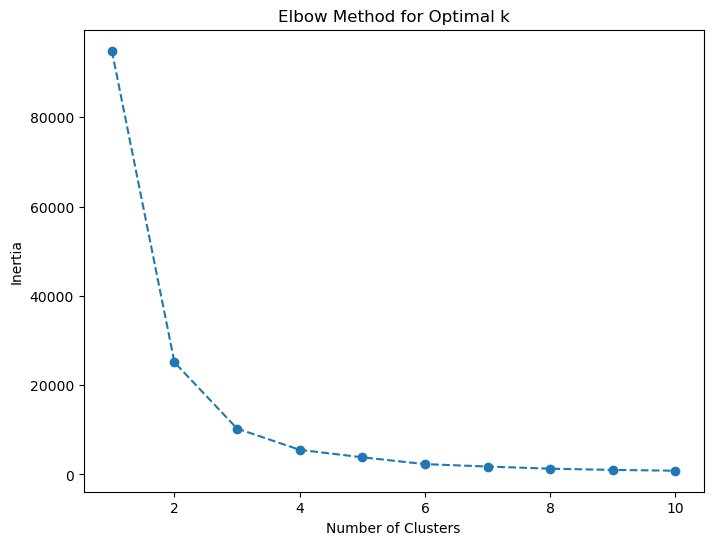

In [36]:
data = delai_achat[['count']]  # Selecting the 'count' column for clustering


inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [37]:
k = 4


kmeans = KMeans(n_clusters=k, random_state=42)
delai_achat['cluster'] = kmeans.fit_predict(data)

# Displaying the DataFrame with the assigned clusters
delai_achat

,delai_achat,type_marque,type_client,count,cluster
0,1.0,mpapro,particulier,70,1
1,2.0,mpapro,particulier,79,2
2,3.0,mpapro,particulier,97,2
3,4.0,mpapro,particulier,99,2
4,5.0,mpapro,particulier,129,2
...,...,...,...,...,...
259,1094.0,mpapro,particulier,1,0
260,1112.0,mpapro,particulier,1,0
261,1134.0,mpapro,particulier,1,0
262,1324.0,mpapro,particulier,1,0


In [38]:
delai_achat.head(50)

,delai_achat,type_marque,type_client,count,cluster
0,1.0,mpapro,particulier,70,1
1,2.0,mpapro,particulier,79,2
2,3.0,mpapro,particulier,97,2
3,4.0,mpapro,particulier,99,2
4,5.0,mpapro,particulier,129,2
5,6.0,mpapro,particulier,106,2
6,7.0,mpapro,particulier,113,2
7,8.0,mpapro,particulier,81,2
8,9.0,mpapro,particulier,63,1
9,10.0,mpapro,particulier,50,1


In [59]:
df_cluster = delai_achat

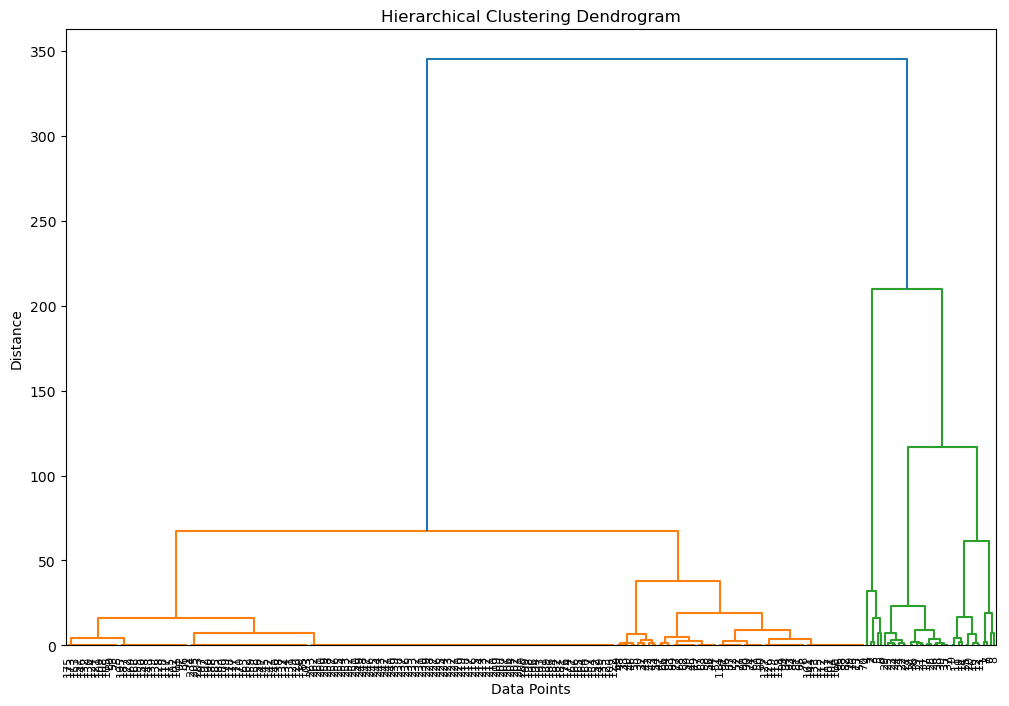

In [58]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# df['cluster'] contains the cluster assignments from k-means

cluster_data = delai_achat[['count', 'cluster']]  # Selecting 'count' and 'cluster' columns


Z = linkage(cluster_data, method='ward')  

# Plotting the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


In [62]:
from scipy.cluster.hierarchy import fcluster
cluster_data = df_cluster[['count', 'cluster']]  


Z = linkage(cluster_data, method='ward')  

distance_threshold = 250
clusters = fcluster(Z, t=distance_threshold, criterion='distance')


df_cluster['hierarchical_cluster'] = clusters


In [64]:
df_cluster.head(50)

,delai_achat,type_marque,type_client,count,cluster,hierarchical_cluster
0,1.0,mpapro,particulier,70,1,2
1,2.0,mpapro,particulier,79,2,2
2,3.0,mpapro,particulier,97,2,2
3,4.0,mpapro,particulier,99,2,2
4,5.0,mpapro,particulier,129,2,2
5,6.0,mpapro,particulier,106,2,2
6,7.0,mpapro,particulier,113,2,2
7,8.0,mpapro,particulier,81,2,2
8,9.0,mpapro,particulier,63,1,2
9,10.0,mpapro,particulier,50,1,2


In [66]:
delai_achat.head(50)

,delai_achat,type_marque,type_client,count,cluster,hierarchical_cluster
0,1.0,mpapro,particulier,70,1,2
1,2.0,mpapro,particulier,79,2,2
2,3.0,mpapro,particulier,97,2,2
3,4.0,mpapro,particulier,99,2,2
4,5.0,mpapro,particulier,129,2,2
5,6.0,mpapro,particulier,106,2,2
6,7.0,mpapro,particulier,113,2,2
7,8.0,mpapro,particulier,81,2,2
8,9.0,mpapro,particulier,63,1,2
9,10.0,mpapro,particulier,50,1,2


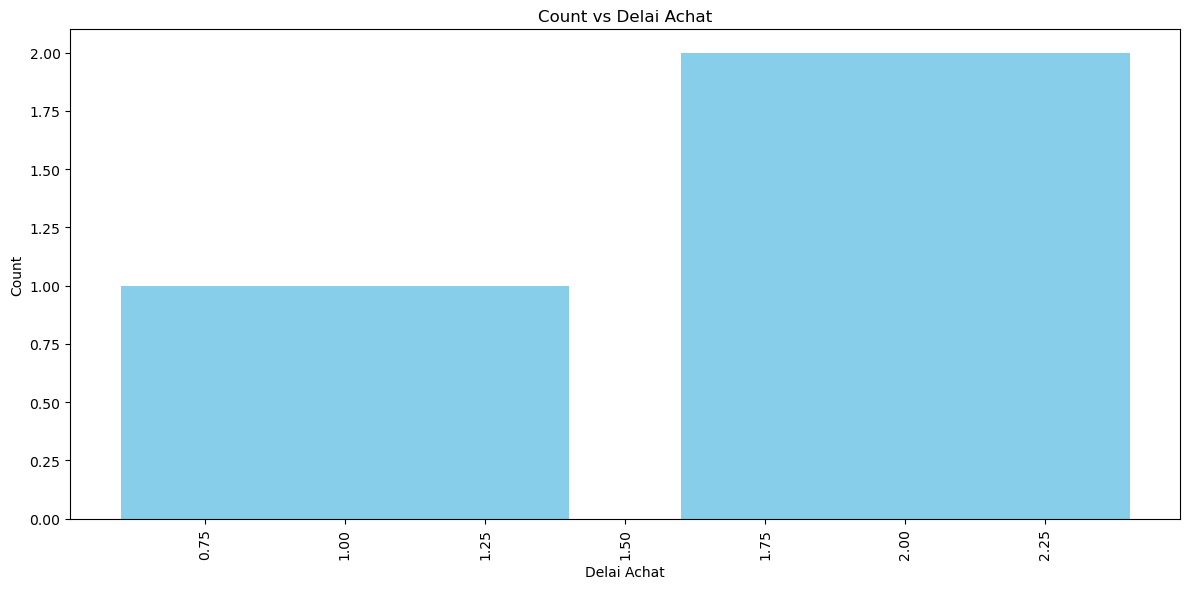

In [70]:
df_sorted = delai_achat.sort_values('delai_achat')

plt.figure(figsize=(12, 6))
plt.bar(df_sorted['hierarchical_cluster'], df_sorted['hierarchical_cluster'], color='skyblue')
plt.xlabel('Delai Achat')
plt.ylabel('Count')
plt.title('Count vs Delai Achat')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [43]:
delai_achat = df_cumul[df_cumul['NBJ']>1].pivot_table(index='delai_achat', columns={'type_marque', 'type_client'}, values='ca',
                                        aggfunc= {'count', 'sum'})
delai_achat

count                    sum            
type_client entreprise particulier entreprise particulier
type_marque     mpapro      mpapro     mpapro      mpapro
delai_achat                                              
1.0               17.0       393.0    2864.82    29036.43
2.0               20.0       373.0    1896.42    26304.04
3.0               18.0       490.0    1998.37    32644.15
4.0               33.0       535.0    3591.00    38437.75
5.0               33.0       610.0    4455.15    42776.38
...                ...         ...        ...         ...
1898.0             NaN         1.0        NaN       33.36
1902.0             NaN         1.0        NaN       32.43
1921.0             NaN         1.0        NaN       24.41
1930.0             NaN         1.0        NaN       87.71
1939.0             NaN         1.0        NaN       28.55

[1301 rows x 4 columns]

In [ ]:
cohort_table

In [47]:
prism.head()

,date_dernier_achat,cycle_de_vie,RFM_comande,type_marque_client,ca,id_user
0,2012-04-17 00:00:00,multiple,1 achat / 50€+,mpapro-entreprise,6034.28,7
1,2012-04-17 00:00:00,one,1 achat 50€ et + / création <6moins,mpapro-entreprise,1560.04,8
2,2012-04-18 00:00:00,multiple,1 achat / 1-49€,mpapro-entreprise,826043.68,191
3,2012-04-18 00:00:00,multiple,1 achat / 50€+,mpapro-entreprise,1632.89,7
4,2012-04-18 00:00:00,multiple,2 achat et +,mpapro-entreprise,249164.33,239


In [48]:
prism.to_excel('prism.xlsx', index=False)

In [ ]:
prism['date_dernier_achat'] = pd.to_datetime(prism['date_dernier_achat'])
prism = prism[prism['date_dernier_achat'].dt.year == 2022]

In [ ]:
prism.head()

In [ ]:
pivot_table_result.head()

In [ ]:
df_cumul['ANCIENNETE'].unique()

In [ ]:

df_cumul[df_cumul['date_premier_achat'] == '']


In [ ]:
df_cumul.to_excel('df_cumul.xlsx', index=False)

In [ ]:
df_annuel.to_excel('df_annuel.xlsx', index=False)

In [ ]:


def categorize_client_oldnew(df):
    # Convert date strings to pandas datetime objects for comparison
    df['date_acquisition'] = pd.to_datetime(df['date_acquisition'])
    df['date_dernier_achat'] = pd.to_datetime(df['date_dernier_achat'])

    df['Type_Client_Nouveau/Ancien'] = df.apply(lambda row: 'Nouveau client' if row['date_acquisition'] == row['date_dernier_achat'] else 'Ancien client', axis=1)
    
    return df


df_annuel = categorize_client_oldnew(df_annuel)


In [ ]:
df_annuel['month_differences']= (df_annuel['date_dernier_achat'] - df_annuel['date_created']) / np.timedelta64(1, 'M')
df_annuel['month_differences'] = df_annuel['month_differences'].astype(int)


In [ ]:

df_annuel['RFM_command'].unique()



## connect powerBI report 

In [ ]:
!pip install ipympl powerbiclient

In [ ]:
from powerbiclient import Report, models
from io import StringIO
from ipywidgets import interact

In [ ]:
# Import the DeviceCodeLoginAuthentication class to authenticate against Power BI
from powerbiclient.authentication import DeviceCodeLoginAuthentication

# Initiate device authentication
device_auth = DeviceCodeLoginAuthentication()

In [ ]:
access_token = device_auth.get_access_token()

In [ ]:
Get-PowerBIWorkspace

In [ ]:
group_id="bafd33d6-8676-4753-b27a-c486a167bdd0"
report_id="d5be23a3-2b40-4bb4-bfad-02c56e1eb0e6" 

In [ ]:
report = Report(group_id=group_id, report_id=report_id, access_token=access_token)
#report = Report(report_id=report_id, auth=device_auth)




In [ ]:
def loaded_callback(event_details):
    print('Report loaded')

def error_callback(event_details):
    print('Error occurred:', event_details)

try:
    report.on('loaded', loaded_callback)
    # Your other report-related operations here
except Exception as e:
    error_callback(str(e))


In [ ]:
report

In [ ]:
QuickVisualize(get_data_config(df_cumul), auth)

In [ ]:
# Filtering for the year 2022 in the 'date_dernier_achat' column
filtered_2022 = df_order_user1[df_order_user1['date_dernier_achat'].dt.year == 2022]

# Creating a pivot table based on specified columns and their values
pivot_table_result = filtered_2022.pivot_table(
    index=['RFM_comande', 'cycle_de_vie'],
    columns=['type_marque_client'],  # Assuming 'type_marque_client' is the correct column name
    values='ca',
    aggfunc={'ca': ['count', 'sum']}  # Aggregating count and sum for the 'ca' column
)


In [ ]:
cohort_table

In [ ]:
df_cumul

In [ ]:
Rfmnewcomand = df_cumul.pivot_table(index='RFM_comande', columns={'type_marque', 'type_client'}, values='ca', aggfunc= {'count', 'sum'})

In [ ]:
#1Cnb_comand
df_annuel.pivot_table(
    index=['annee'],
    columns=['type_marque', 'type_client'],
    values=['ca', 'nb_commande'],
    aggfunc={'ca': ['count', 'sum'], 'nb_commande': 'sum'}
)

In [ ]:
freq_comnd = df_annuel.pivot_table(
    index=['annee', 'NBJ'],
    columns=['type_marque', 'type_client'],
    values='nb_commande',
    aggfunc='sum'
)


In [ ]:
freq_comnd

## excell report and for instance and pdf viz



In [ ]:
grouped = df_annuel.groupby(['annee','NBJ', 'type_marque', 'type_client']).agg({'ca': ['count', 'sum'], 'nb_commande': 'sum'})


In [ ]:
grouped

In [ ]:
freq1

In [ ]:


grouped = df_annuel.groupby(['annee','NBJ', 'type_marque', 'type_client']).agg({'ca': ['count', 'sum'], 'nb_commande': 'sum'})


In [ ]:
grouped

In [ ]:
grouped = df_annuel.pivot_table(index='annee', columns={'type_marque', 'type_client'}, aggfunc={'ca': ['count', 'sum'], 'nb_commande': 'sum'} ,values=['ca', 'nb_commande'],)


In [ ]:
pivot_table = df_annuel.pivot_table(
    index=['annee', 'type_marque', 'type_client'],
    values=['ca', 'nb_commande'],
    aggfunc={'ca': ['count', 'sum'], 'nb_commande': 'sum'}
)

In [ ]:
pivot_table

In [ ]:
cohort.head()

In [ ]:
Rfmnewcomand.to_excel('Rfmnewcomand.xlsx')


In [ ]:
indicateur1b =df_annuel.groupby(['annee','type_marque', 'type_client']).agg(
    NBJ_mean=('NBJ', 'mean'), nb_comand=('nb_commande', 'mean'))

In [ ]:
indicateur1bp = df_annuel.pivot_table(index='annee', columns={'type_marque', 'type_client'}, aggfunc={'NBJ': 'mean', 'nb_commande': 'mean'} ,values=['NBJ', 'nb_commande'],)


In [ ]:
indicateur1b

In [ ]:
indicateur1bp

In [ ]:
#update existing excell

In [ ]:
indicateur1 = df_cumul.groupby(['type_marque', 'type_client']).agg(
    NB_Client=('id_user', 'count'), 
    ca_sum=('ca', 'sum'), 
    ca_mean=('ca', 'mean'), 
    ca_median=('ca', 'median'), 
    NBJ_sum=('NBJ', 'sum'),
    NBJ_mean=('NBJ', 'mean'), 
    NBJ_median=('NBJ', 'median'), 
    nb_command=('nb_commande', 'sum')
)


In [ ]:
indicateur1

In [ ]:
indicateur1a.head(50)


In [ ]:
Annuels = df_annuel.pivot_table(index='annee', columns={'type_marque', 'type_client'}, aggfunc= {'count', 'sum'}, values='ca')
Annuels

In [ ]:
delai_achat = df_cumul[df_cumul['NBJ']>1].pivot_table(index='delai_achat', columns={'type_marque', 'type_client'}, values='ca',
                                        aggfunc= {'count', 'sum'})
delai_achat

In [ ]:
filtered_delai_achat = df_cumul[df_cumul['NBJ'] > 1]  # Filtering based on 'NBJ' > 1

filtered_delai_achat = filtered_delai_achat.groupby(['delai_achat', 'type_marque', 'type_client'])['ca'].agg(['count', 'sum'])

# Reshaping the DataFrame to have 'type_marque' and 'type_client' as columns
filtered_delai_achat

In [ ]:
df_cumul['annee_PREMIER_ACHAT']=df_cumul['date_premier_achat'].dt.year
df_cumul[df_cumul['NBJ']==1].pivot_table(index='annee_PREMIER_ACHAT', columns={'type_marque', 'type_client'}, values='ca',\
                     aggfunc= {'count', 'sum'})

In [ ]:
# Filter the DataFrame for NBJ equal to 1

df_cumul['annee_PREMIER_ACHAT']=df_cumul['date_premier_achat'].dt.year
filtered_data = df_cumul[df_cumul['NBJ'] == 1]

# Group the filtered data by 'annee_PREMIER_ACHAT', 'type_marque', and 'type_client'
grouped_data = filtered_data.groupby(['annee_PREMIER_ACHAT', 'type_marque', 'type_client'])

# Aggregate the 'ca' column using count and sum
aggregated_data = grouped_data.agg({'ca': ['count', 'sum']})

# Reset index to flatten the multi-index columns
aggregated_data = aggregated_data.reset_index()
aggregated_data


In [ ]:
recence = df_cumul.pivot_table(index='RECENCE', columns={'type_marque', 'type_client'}, values='ca', aggfunc= {'count', 'sum'})
recence

In [ ]:
freq1 = df_cumul.groupby(['NBJ', 'type_marque', 'type_client'])['ca'].agg(['count', 'sum'])

In [ ]:
Indicateurs_Annuels =df_annuel.pivot_table(index='annee', columns={'type_marque_client'}, aggfunc= {'count', 'sum'}, values='ca').\
reset_index()

In [ ]:
Indicateurs_Annuels = df_annuel.groupby(['annee', 'type_marque_client']).agg({'ca': ['count', 'sum']})
Indicateurs_Annuels

In [ ]:
df_cumul[df_cumul['date_acquisition']>='2017-01-01 00:00:00'].pivot_table(index={'ANCIENNETE'},
columns={'type_marque', 'type_client'}, aggfunc= {'count', 'sum'}, values='ca').reset_index()

In [ ]:
filtered_df = df_cumul[df_cumul['date_acquisition'] >= '2017-01-01 00:00:00']

# Grouping and aggregating the data
prospect = filtered_df.groupby(['ANCIENNETE', 'type_marque', 'type_client']).agg({
    'ca': ['count', 'sum']
}).reset_index()

prospect.head(50)

In [ ]:
df_annuel

In [ ]:
df_annuel.pivot_table(index={'annee', 'ANCIENNETE'}, columns={'type_marque', 'type_client'}, aggfunc= {'count', 'sum'},\
                      values='ca').reset_index()

In [ ]:
dfAnn =df_annuel.groupby(['annee', 'ANCIENNETE', 'type_marque', 'type_client'])['ca'].agg(['count', 'sum']).reset_index()

In [ ]:
 dfAnn[dfAnn['annee'] == 2022]


In [ ]:
Anciennete = filtered_df.groupby(['ANCIENNETE', 'type_marque', 'type_client']).agg({
    'ca': ['count', 'sum']
}).reset_index()

prospect.head(50)

In [ ]:
#main   
from gspread_dataframe import set_with_dataframe
import gspread
sa = gspread.service_account()
sh = sa.open("data viz")
worksheet_name = "Freauence"
worksheet = sh.worksheet(worksheet_name)
set_with_dataframe(wks, freq, include_index=True)  

In [ ]:
range_to_clear = "A1:E83"


wks.batch_clear([range_to_clear])

In [ ]:
wks.set_dataframe(freq, 'A1')


In [ ]:
header_row = 1
for c_idx, header in enumerate(freq_df.columns, start=1):
    print(c_idx)
    print(header)
    ws.cell(row=header_row, column=c_idx, value=header)

# Write the DataFrame to Excel starting from cell A2
data_start_row = header_row + 1
for r_idx, row in enumerate(pd.DataFrame(columns=freq_df.columns, data=freq_df).itertuples(), start=data_start_row):
    for c_idx, value in enumerate(row[1:], start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)


In [ ]:
sa = gspread.service_account()
wb = sa.open("data viz")
ws = wb.worksheet("Freauence")

header_row = 4  # Set the header row here
data_row = header_row + 1  # Set the data starting row

for r_idx, header in enumerate(freq_df.columns, start=1):
    header = header.replace("'", "").replace("(", "").replace(")", "")
    li = list(header.split(","))
    
    if len(li) == 1:
        header_row = 4
    else:
        header_row = 1

    cell_address = gspread.utils.a1_to_rowcol(f"A{header_row}")
    ws.update_cell(cell_address[0], cell_address[1] + r_idx - 1, li[0])

    for c_idx, value in enumerate(li[1:], start=1):
        cell_address = gspread.utils.a1_to_rowcol(f"A{header_row + c_idx}")
        ws.update_cell(cell_address[0], cell_address[1] + r_idx - 1, value)

        
for r_idx, row in enumerate(pd.DataFrame(columns=freq.columns, data=freq).itertuples(), start=data_row):
    ws.update_cell(r_idx, 1, r_idx - header_row)
    for c_idx, value in enumerate(row[1:], start=2):
        ws.update_cell(r_idx, c_idx, value)        

In [ ]:
import time
import gspread
import pandas as pd
from gspread.exceptions import APIError


sa = gspread.service_account()
wb = sa.open("data viz")
ws = wb.worksheet("Freauence")

header_row = 4  
data_row = header_row + 1  

def update_cell_with_retry(row, col, value):
    max_retries = 4 
    retries = 0
    
    while retries < max_retries:
        try:
            ws.update_cell(row, col, value)  
            break  
        except APIError as e:
            if e.response.status_code == 429:  
                print("Rate limit exceeded. Waiting and retrying...")
                time.sleep(10)  
                retries += 1
            else:
                raise  

    if retries == max_retries:
        print("Max retries reached. Failed to update cell.")



for r_idx, header in enumerate(freq_df.columns, start=1):
    header = header.replace("'", "").replace("(", "").replace(")", "")
    li = list(header.split(","))
    
    if len(li) == 1:
        header_row = 4
    else:
        header_row = 1

    cell_address = gspread.utils.a1_to_rowcol(f"A{header_row}")
    update_cell_with_retry(cell_address[0], cell_address[1] + r_idx - 1, li[0])

    for c_idx, value in enumerate(li[1:], start=1):
        cell_address = gspread.utils.a1_to_rowcol(f"A{header_row + c_idx}")
        update_cell_with_retry(cell_address[0], cell_address[1] + r_idx - 1, value)

# Loop for updating data rows
for r_idx, row in enumerate(pd.DataFrame(columns=freq.columns, data=freq).itertuples(), start=data_row):
    update_cell_with_retry(r_idx, 1, r_idx - header_row)
    for c_idx, value in enumerate(row[1:], start=2):
        update_cell_with_retry(r_idx, c_idx, value)


In [ ]:
#kaustubh1
import openpyxl
wb = openpyxl.load_workbook('mpapro.xlsx')
ws = wb['FREQUENCE']  
header_row = 1
data_row = header_row + 4
for r_idx, header in enumerate(freq_df.columns, start=1):
    header = header.replace("'", "")
    header = header.replace("(", "")
    header = header.replace(")", "")
    li = list(header.split(","))
    if(len(li) == 1):
        header_row = 4
    else:
        header_row = 1
    ws.cell(row=header_row, column=r_idx, value=li[0])
    for c_idx, value in enumerate(li[1:], start=1):
        ws.cell(row=header_row + c_idx, column=r_idx, value=value)


for r_idx, row in enumerate(pd.DataFrame(columns=freq.columns, data=freq).itertuples(), start=data_row):
    ws.cell(row=r_idx, column=1, value=r_idx-4)
    for c_idx, value in enumerate(row[1:], start=2):
        ws.cell(row=r_idx, column=c_idx, value=value)
        print(r_idx,c_idx,value)

wb.save('data viz')        

In [ ]:
import openpyxl
freq_df = pd.DataFrame(freq.to_records())


#ws['A1'] = freq
header_row = 3
for c_idx, header in enumerate(freq.columns, start=1):
    print(c_idx)
#    ws.cell(row=header_row, column=c_idx, value=header)

# Write the DataFrame to Excel starting from cell A2
data_start_row = header_row + 4
for r_idx, row in enumerate(pd.DataFrame(columns=freq.columns, data=freq).itertuples(), start=data_start_row):
    for c_idx, value in enumerate(row[1:], start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)

wb.save('mpapro.xlsx')
#ws['A1'] = df_cumul.pivot_table(index='NBJ', columns={'type_marque', 'type_client'}, values='ca', aggfunc= {'count', 'sum'})
# for col_num, value in enumerate(df_cumul.columns.values, 1):
#     ws.cell(row=1, column=col_num, value=value)

# # Write data
# for row_num, row in enumerate(df_cumul.itertuples(), 2):
#     for col_num, value in enumerate(row[1:], 1):
#         ws.cell(row=row_num, column=col_num, value=value)

# # Save the workbook
# wb.save('mpapro.xlsx')


In [ ]:
dfe.head()

In [ ]:
#################################

In [ ]:
import os
path = os.path.join(os.getcwd(), "mpapro.xlsx")
writer = pd.ExcelWriter(path, engine='xlsxwriter')


In [ ]:
df_cumul.groupby(['type_marque', 'type_client']).agg(
    NB_Client=('id_user', 'count'), ca_sum=('ca', 'sum'), ca_mean=('ca', 'mean'), ca_median=('ca', 'median'),
    NBJ_mean=('NBJ', 'mean'), NBJ_median=('NBJ', 'median')).reset_index()\
.to_excel(writer, 'Indicateurs1')


In [ ]:
writer.close()

In [ ]:
df_annuel.pivot_table(index='annee', columns={'type_marque', 'type_client'}, aggfunc= {'count', 'sum'}, values='ca').\
reset_index().to_excel(writer, 'Indicateurs_Annuels')

In [ ]:
df_cumul.pivot_table(index='NBJ', columns={'type_marque', 'type_client'}, values='ca', aggfunc= {'count', 'sum'})\
.to_excel(writer, 'FREQUENCE')

In [ ]:
df_cumul.pivot_table(index='NBJ', columns={'type_marque', 'type_client'}, values='ca', aggfunc= {'count', 'sum'})

In [ ]:
df_cumul[df_cumul['NBJ']>1].pivot_table(index='delai_achat', columns={'type_marque', 'type_client'}, values='ca',
                                        aggfunc= {'count', 'sum'}).to_excel(writer, 'delai_achat')

In [ ]:
df_cumul.pivot_table(index='RECENCE', columns={'type_marque', 'type_client'}, values='ca', aggfunc= {'count', 'sum'})\
.to_excel(writer, 'RECENCE')

In [ ]:
df_cumul['annee_PREMIER_ACHAT']=df_cumul['date_premier_achat'].dt.year
df_cumul[df_cumul['NBJ']==1].pivot_table(index='annee_PREMIER_ACHAT', columns={'type_marque', 'type_client'}, values='ca',\
                     aggfunc= {'count', 'sum'}).to_excel(writer, 'RETENTION')

In [ ]:
df_annuel.pivot_table(index={'annee', 'ANCIENNETE'}, columns={'type_marque', 'type_client'}, aggfunc= {'count', 'sum'},\
                      values='ca').reset_index().to_excel(writer, 'ANCIENNETE')

In [ ]:
df_cumul[df_cumul['date_acquisition']>='2017-01-01 00:00:00'].pivot_table(index={'ANCIENNETE'},
columns={'type_marque', 'type_client'}, aggfunc= {'count', 'sum'}, values='ca').reset_index().to_excel(writer, 'PROSPECT')

In [ ]:
writer.close()

In [ ]:
def viziualization(df_cumul, df_annuel):
    indicateur1 = df_cumul.groupby(['type_marque', 'type_client']).agg(
    NB_Client=('id_user', 'count'), ca_sum=('ca', 'sum'), ca_mean=('ca', 'mean'), ca_median=('ca', 'median'),
    NBJ_mean=('NBJ', 'mean'), NBJ_median=('NBJ', 'median')).reset_index() #answere for pie and 3rd graph
    
    #Indicateurs_Annuels = df_annuel.groupby(['annee', 'type_marque_client'])['ca'].agg(['count', 'sum'])
    #Indicateurs_Annuels
    
    
    #4th chart
    frequence =  df_cumul.groupby(['NBJ', 'type_marque', 'type_client'])['ca'].agg(['count', 'sum'])
    total_count = frequence['count'].sum()
    total_sum = frequence['sum'].sum()
    percentage_count = (frequence['count'] / total_count * 100)
    percentage_sum = (frequence['sum'] / total_sum * 100)
    frequence = pd.concat([percentage_count, percentage_sum], keys=['Count%', 'Sum%'], axis=1)
    frequence
    
    #5th chart 
    RETENTION_filtered = df_cumul[df_cumul['NBJ'] == 1]
    RETENTION = RETENTION_filtered.groupby(['annee_PREMIER_ACHAT', 'type_marque_client'])['ca'].agg(['count', 'sum'])
    total_count = RETENTION.groupby(level=0)['count'].transform('sum')
    total_sum = RETENTION.groupby(level=0)['sum'].transform('sum')
    RETENTION['count_percent'] = (RETENTION['count'] / total_count) * 100
    RETENTION['sum_percent'] = (RETENTION['sum'] / total_sum) * 100
    RETENTION
    
    #6th chart 
    df_cumul['delai_achat'] = ((df_cumul['date_dernier_achat'].dt.to_period('M').astype(int) -
                        df_cumul['date_premier_achat'].dt.to_period('M').astype(int)) / (df_cumul['NBJ']-1)).apply(np.ceil)
    delai_achat_filtered = df_cumul[df_cumul['NBJ'] > 1]
    delai_achat = delai_achat_filtered.groupby(['delai_achat', 'type_marque_client'])['ca'].agg(['count', 'sum'])
    delai_achat
    
    #7th chart
    # Convert 'date_acquisition' to datetime if it's not already in datetime format
    df_cumul['date_acquisition'] = pd.to_datetime(df_cumul['date_acquisition'])
    prospect_filtered = df_cumul[df_cumul['date_acquisition'] >= '2017-01-01 00:00:00']
    # Group by 'ANCIENNETE' and 'type_marque_client', and aggregate count and sum
    PROSPECT = prospect_filtered.groupby(['ANCIENNETE', 'type_marque_client'])['ca'].agg(['count', 'sum'])
    total_sum = PROSPECT['sum'].sum() 
    PROSPECT_percentage_count = (PROSPECT['count'] / total_count * 100)
    PROSPECT_percentage_sum = (PROSPECT['sum'] / total_sum * 100)

    # Combine the two percentage DataFrames
    PROSPECT_percentage = pd.concat([PROSPECT_percentage_count, PROSPECT_percentage_sum], keys=['Count%', 'Sum%'], axis=1)
    PROSPECT_percentage
    
    return indicateur1, Indicateurs_Annuels, frequence, RETENTION, delai_achat, PROSPECT_percentage


    
    
    
    
    

In [ ]:
frequence = df_cumul.groupby(['NBJ', 'type_marque_client'])['ca'].agg(['count', 'sum'])
total_count = frequence['count'].sum()
total_sum = frequence['sum'].sum()
percentage_count = (frequence['count'] / total_count * 100)
percentage_sum = (frequence['sum'] / total_sum * 100)
frequence = pd.concat([percentage_count, percentage_sum], keys=['Count%', 'Sum%'], axis=1).reset_index()
frequence

In [ ]:
import pandas as pd

# Performing groupby and aggregation operations
indicateur1 = df_cumul.groupby(['type_marque_client']).agg(
    NB_Client=('id_user', 'count'), ca_sum=('ca', 'sum'), ca_mean=('ca', 'mean'), ca_median=('ca', 'median'),
    NBJ_mean=('NBJ', 'mean'), NBJ_median=('NBJ', 'median')).reset_index()

#Indicateurs_Annuels = df_annuel.groupby(['annee', 'type_marque_client'])['ca'].agg(['count', 'sum'])

frequence = df_cumul.groupby(['NBJ', 'type_marque_client'])['ca'].agg(['count', 'sum'])
total_count = frequence['count'].sum()
total_sum = frequence['sum'].sum()
percentage_count = (frequence['count'] / total_count * 100)
percentage_sum = (frequence['sum'] / total_sum * 100)
frequence = pd.concat([percentage_count, percentage_sum], keys=['Count%', 'Sum%'], axis=1).reset_index()

RETENTION_filtered = df_cumul[df_cumul['NBJ'] == 1]
RETENTION = RETENTION_filtered.groupby(['annee_PREMIER_ACHAT', 'type_marque_client'])['ca'].agg(['count', 'sum'])
total_count = RETENTION.groupby(level=0)['count'].transform('sum')
total_sum = RETENTION.groupby(level=0)['sum'].transform('sum')
percentageretention_count = (RETENTION['count'] / total_count) * 100
percentageretention_sum = (RETENTION['sum'] / total_sum) * 100
RETENTION = pd.concat([percentageretention_count, percentageretention_sum], keys=['Count%', 'Sum%'], axis=1).reset_index()

df_cumul['delai_achat'] = ((df_cumul['date_dernier_achat'].dt.to_period('M').astype(int) -
                    df_cumul['date_premier_achat'].dt.to_period('M').astype(int)) / (df_cumul['NBJ'] - 1)).apply(np.ceil)
delai_achat_filtered = df_cumul[df_cumul['NBJ'] > 1]
delai_achat = delai_achat_filtered.groupby(['delai_achat', 'type_marque_client'])['ca'].agg(['count', 'sum']).reset_index()

df_cumul['date_acquisition'] = pd.to_datetime(df_cumul['date_acquisition'])
prospect_filtered = df_cumul[df_cumul['date_acquisition'] >= '2017-01-01 00:00:00']
PROSPECT = prospect_filtered.groupby(['ANCIENNETE', 'type_marque_client'])['ca'].agg(['count', 'sum'])
total_count = PROSPECT['count'].sum()
total_sum = PROSPECT['sum'].sum()
PROSPECT_percentage_count = (PROSPECT['count'] / total_count * 100)
PROSPECT_percentage_sum = (PROSPECT['sum'] / total_sum * 100)
PROSPECT_percentage = pd.concat([PROSPECT_percentage_count, PROSPECT_percentage_sum], keys=['Count%', 'Sum%'], axis=1).reset_index()


df_prospect[df_prospect['date_acquisition']>='2017-01-01 00:00:00'].groupby(['type_marque', 'type_client']).agg(
    NB_Client=('id_user', 'count')).reset_index()



In [ ]:
df_prospect

In [ ]:
frequence1 = df_cumul.groupby(['NBJ', 'type_marque_client'])['ca'].agg(['count', 'sum'])
frequence1.reset_index()


In [ ]:
frequence.shape

In [ ]:
merged_data1 = pd.merge(frequence, RETENTION, on='type_marque_client', how='outer', suffixes=('_frequence', '_retention'))
merged_data2 = pd.merge(merged_data1, delai_achat, on='type_marque_client', how='outer')
merged_data3 = pd.merge(merged_data2, PROSPECT_percentage, on='type_marque_client', how='outer')
merged_data = pd.merge(merged_data3, indicateur1, on='type_marque_client', how='outer')

# Replace missing values with NaN
merged_data = merged_data.where(pd.notnull(merged_data), None)

In [ ]:

merged_data1 = frequence.merge(RETENTION, on=['type_marque_client'],suffixes=('_frequence', '_retention'))
merged_data2 = merged_data1.merge(delai_achat, on=['type_marque_client'])
merged_data = merged_data2.merge(PROSPECT_percentage, on=['type_marque_client'])
merged_data = merged_data.merge(indicateur1, on=['type_marque_client'])

In [ ]:
df_annuel

In [ ]:
upload_df_s3(df_annuel,"sortiempa", "df_annuel_viz")

In [ ]:
indicateur1

In [ ]:
delai_achat.head()

In [ ]:
RETENTION.head()

In [ ]:
frequence

In [ ]:
#merged_data1.head(50) 
#merged_data1[merged_data1['annee_PREMIER_ACHAT'] == 'belleboite-particulier']
merged_data[(merged_data['annee_PREMIER_ACHAT'] == 2017) & (merged_data['NBJ'] == 1)]

In [ ]:
merged_data.duplicated().sum()

In [ ]:
analyz2custom = df_cumul[['type_marque_client', 'ca']]

import matplotlib.pyplot as plt

# Assuming you have your data in a DataFrame named df
data = analyz2custom.groupby('type_marque_client')['ca'].sum()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of "ca" by type_marque_client')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

plt.show()

In [ ]:
analyz2custom = df_cumul[['type_marque_client', 'ca']]

import matplotlib.pyplot as plt

# Assuming you have your data in a DataFrame named df
data = analyz2custom.groupby('type_marque_client')['ca'].sum()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of "ca" by type_marque_client')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

plt.show()

In [ ]:

df_cumul.groupby(['type_marque', 'type_client']).agg(
    NB_Client=('id_user', 'count'), ca_sum=('ca', 'sum'), ca_mean=('ca', 'mean'), ca_median=('ca', 'median'),
    NBJ_mean=('NBJ', 'mean'), NBJ_median=('NBJ', 'median')).reset_index()

In [ ]:
data = df_cumul.groupby(['type_marque', 'type_client']).agg(
    NB_Client=('id_user', 'count'), ca_sum=('ca', 'sum'), ca_mean=('ca', 'mean'), ca_median=('ca', 'median'),
    NBJ_mean=('NBJ', 'mean'), NBJ_median=('NBJ', 'median')).reset_index()

# Select the data for the "ca_sum" column
ca_sum_data = data['ca_sum']

# Labels for the pie chart
labels = data['type_marque'] + " - " + data['type_client']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(ca_sum_data, labels=labels, autopct='%1.1f%%', startangle=140)

# Title
plt.title('Percentage of "ca_sum" by type_marque and type_client')

# Display the chart
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.show()

In [ ]:
df_annuel

In [ ]:
Indicateurs_Annuels =df_annuel.pivot_table(index='annee', columns={'type_marque_client'}, aggfunc= {'count', 'sum'}, values='ca').\
reset_index()
df_after_2017 = Indicateurs_Annuels[Indicateurs_Annuels['annee'] > 2017]

In [ ]:
grouped = df_annuel.groupby(['annee', 'type_marque_client'])['ca'].agg(['count', 'sum'])
#Indicateurs_Ann = grouped.unstack(level=1).reset_index()

In [ ]:
grouped.head(50)

In [ ]:
df_annuel.head()

In [ ]:
years  =  df_after_2017['annee']
total_count = df_after_2017['count']['astickers-particulier']
total_sum = df_after_2017['sum']['astickers-particulier']
fig, ax1 = plt.subplots()

years  =  df_after_2017['annee']
total_count = df_after_2017['count']['astickers-particulier']
total_sum = df_after_2017['sum']['astickers-particulier']


#plt.bar(year, count_percent)
ax1.bar(years, total_sum, color='skyblue')
ax1.set_xlabel('Categories')
ax1.set_ylabel('total CA', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')


ax2 = ax1.twinx()
ax1.plot(years, total_count, color='orange', marker='o')


ax2.set_ylabel('sum ca percent ', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


plt.show()

In [ ]:
ind1 = df_cumul.groupby(['type_marque', 'type_client']).agg(
    NB_Client=('id_user', 'count'), 
    ca_sum=('ca', 'sum'), 
    ca_mean=('ca', 'mean'), 
    ca_median=('ca', 'median'),
    NBJ_mean=('NBJ', 'mean'), 
    NBJ_median=('NBJ', 'median')
).reset_index()

In [ ]:
ind1

In [ ]:
data = df_cumul.groupby(['type_marque', 'type_client']).agg(
    NB_Client=('id_user', 'count'), ca_sum=('ca', 'sum'), ca_mean=('ca', 'mean'), ca_median=('ca', 'median'),
    NBJ_mean=('NBJ', 'mean'), NBJ_median=('NBJ', 'median')).reset_index()
data['type_marque_client'] = data['type_marque'] + ' - ' + data['type_client']

sorted_data = data.sort_values(by='NBJ_median', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(sorted_data['type_marque_client'], sorted_data['NBJ_median'], color='skyblue')

# Set labels and title
plt.xlabel('NBJ Median')
plt.ylabel('Type Marque')
#plt.title(f'NBJ Median by Type Marque (Type Client: {type_marque})')

# Show the chart
plt.show()

In [ ]:
pivot_table = df_cumul.pivot_table(index='NBJ', columns={'type_marque', 'type_client'}, values='ca', aggfunc= {'count', 'sum'})

In [ ]:
pivot_table

In [ ]:
grouped = df_cumul.groupby(['NBJ', 'type_marque', 'type_client'])['ca'].agg(['count', 'sum'])

# Calculate total count and sum without creating a pivot table
total_count = grouped['count'].sum()
total_sum = grouped['sum'].sum()

# Calculate percentages directly without pivot_table
percentage_count = (grouped['count'] / total_count * 100)
percentage_sum = (grouped['sum'] / total_sum * 100)

# Combine the two percentage Series into a DataFrame
pivot_table_percentage = pd.concat([percentage_count, percentage_sum], keys=['Count%', 'Sum%'], axis=1)
pivot_table_percentage

In [ ]:
# answere 3
pivot_table = df_cumul.pivot_table(index='NBJ', columns={'type_marque', 'type_client'}, values='ca', aggfunc= {'count', 'sum'})
total_count = pivot_table['count'].sum()
total_sum = pivot_table['sum'].sum()
pivot_table_percentage_count = (pivot_table['count'] / total_count * 100)
pivot_table_percentage_sum = (pivot_table['sum'] / total_sum * 100)

# Combine the two percentage DataFrames
pivot_table_percentage = pd.concat([pivot_table_percentage_count, pivot_table_percentage_sum], keys=['Count%', 'Sum%'], axis=1)
pivot_table_percentage

In [ ]:
+
 
df_cumul['annee_PREMIER_ACHAT']=df_cumul['date_premier_achat'].dt.year
RETENTION = df_cumul[df_cumul['NBJ']==1].pivot_table(index='annee_PREMIER_ACHAT', columns={'type_marque_client'}, values='ca',\
                     aggfunc= {'count', 'sum'})
RETENTION_after_2017 = RETENTION[RETENTION.index >= 2017]

merged_df = pd.merge(RETENTION_after_2017, Indicateurs_Annuels,left_on='annee_PREMIER_ACHAT', right_on='annee', how='left')
merged_df['count_percent'] = (merged_df.loc[:, ('count_x', 'astickers-particulier')].values /
                              merged_df.loc[:, ('count_y', 'astickers-particulier')].values) * 100
merged_df['sum_percent'] = (merged_df.loc[:, ('sum_x', 'astickers-particulier')].values /
                              merged_df.loc[:, ('sum_y', 'astickers-particulier')].values) * 100

In [ ]:
RETENTION_filtered = df_cumul[df_cumul['NBJ'] == 1]

# Group RETENTION_filtered by 'annee_PREMIER_ACHAT' and 'type_marque_client', and aggregate count and sum
RETENTION = RETENTION_filtered.groupby(['annee_PREMIER_ACHAT', 'type_marque_client'])['ca'].agg(['count', 'sum'])
# Calculate total count and total sum per 'annee_PREMIER_ACHAT'
total_count = RETENTION.groupby(level=0)['count'].transform('sum')
total_sum = RETENTION.groupby(level=0)['sum'].transform('sum')

# Calculate count percent and sum percent
RETENTION['count_percent'] = (RETENTION['count'] / total_count) * 100
RETENTION['sum_percent'] = (RETENTION['sum'] / total_sum) * 100

RETENTION
# Drop unnecessary columns if needed
#merged_df.drop(['annee'], axis=1, inplace=True)

In [ ]:
fig, ax1 = plt.subplots()

year = grouped['']['annee_PREMIER_ACHAT']
count_percent = grouped['count_percent']
sum_percent = grouped['sum_percent']


#plt.bar(year, count_percent)
ax1.bar(year, count_percent, color='skyblue')
ax1.set_xlabel('year')
ax1.set_ylabel('count percent', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')


ax2 = ax1.twinx()
ax1.plot(year, sum_percent, color='orange', marker='o')


ax2.set_ylabel('sum ca percent ', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


plt.show()



In [ ]:
retention_filtered = df_cumul[df_cumul['NBJ'] == 1]

# Group by 'annee_PREMIER_ACHAT' and 'type_marque_client' and aggregate data without pivot_table
grouped = retention_filtered.groupby(['annee_PREMIER_ACHAT', 'type_marque_client'])['ca'].agg(['count', 'sum'])
grouped

In [ ]:
#astickerspaericular_merged_df =  merged_df[['sum_percent', 'count_percent','annee']]

In [ ]:
#astickerspaericular_merged_df.to_csv("astickerspaericular_merged_dfanalyze4.csv", index=False)  

In [ ]:
#analyze4countNsum = pd.read_csv("astickerspaericular_merged_dfanalyze4.csv")

In [ ]:
upload_df_s3(grouped,"sortiempa", "analyze4Retention")

In [ ]:
df_cumul['date_premier_achat'] = pd.to_datetime(df_cumul['date_premier_achat'])

df_cumul['annee_PREMIER_ACHAT']=df_cumul['date_premier_achat'].dt.year
RETENTION = df_cumul[df_cumul['NBJ']==1].pivot_table(index='annee_PREMIER_ACHAT', columns={'type_marque_client'}, values='ca',\
                     aggfunc= {'count', 'sum'})
RETENTION_after_2017 = RETENTION[RETENTION.index >= 2017]

merged_df = pd.merge(RETENTION_after_2017, Indicateurs_Annuels,left_on='annee_PREMIER_ACHAT', right_on='annee', how='left')
merged_df['count_percent'] = (merged_df.loc[:, ('count_x', 'astickers-particulier')].values /
                              merged_df.loc[:, ('count_y', 'astickers-particulier')].values) * 100
merged_df['sum_percent'] = (merged_df.loc[:, ('sum_x', 'astickers-particulier')].values /
                              merged_df.loc[:, ('sum_y', 'astickers-particulier')].values) * 100

fig, ax1 = plt.subplots()

year = merged_df['annee']
count_percent = merged_df['count_percent']
sum_percent = merged_df['sum_percent']


#plt.bar(year, count_percent)
ax1.bar(year, count_percent, color='skyblue')
ax1.set_xlabel('year')
ax1.set_ylabel('count percent', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')


ax2 = ax1.twinx()
ax1.plot(year, sum_percent, color='orange', marker='o')


ax2.set_ylabel('sum ca percent ', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


plt.show()



In [ ]:
df_cumul['date_dernier_achat'] = pd.to_datetime(df_cumul['date_dernier_achat'])
df_cumul['date_premier_achat'] = pd.to_datetime(df_cumul['date_premier_achat'])
df_cumul['delai_achat'] = ((df_cumul['date_dernier_achat'].dt.to_period('M').astype(int) -
                        df_cumul['date_premier_achat'].dt.to_period('M').astype(int)) / (df_cumul['NBJ']-1)).apply(np.ceil)
delai_achat= df_cumul[df_cumul['NBJ']>1].pivot_table(index='delai_achat', columns={'type_marque_client'}, values='ca',
                                        aggfunc= {'count', 'sum'})

In [ ]:
df_cumul['date_dernier_achat'] = pd.to_datetime(df_cumul['date_dernier_achat'])
df_cumul['date_premier_achat'] = pd.to_datetime(df_cumul['date_premier_achat'])
df_cumul['delai_achat'] = ((df_cumul['date_dernier_achat'].dt.to_period('M').astype(int) -
                        df_cumul['date_premier_achat'].dt.to_period('M').astype(int)) / (df_cumul['NBJ']-1)).apply(np.ceil)
delai_achat= df_cumul[df_cumul['NBJ']>1].pivot_table(index='delai_achat', columns={'type_marque_client'}, values='ca',
                                        aggfunc= {'count', 'sum'})
x = delai_achat.index
y = delai_achat['count']['astickers-particulier']
plt.title('Nombre de clients en fonction du délai de réachat moyen (en mois)')
plt.bar(x, y)
plt.show()

In [ ]:
RETENTION[RETENTION.index >= 2017]

In [ ]:
ANCIENNETE = df_annuel.pivot_table(index={'annee', 'ANCIENNETE'}, columns={'type_marque', 'type_client'}, aggfunc= {'count', 'sum'},\
                      values='ca').reset_index()

In [ ]:
# Convert 'date_acquisition' to datetime if it's not already in datetime format
df_cumul['date_acquisition'] = pd.to_datetime(df_cumul['date_acquisition'])

# Filter the DataFrame based on the condition
prospect_filtered = df_cumul[df_cumul['date_acquisition'] >= '2017-01-01 00:00:00']

# Group by 'ANCIENNETE' and 'type_marque_client', and aggregate count and sum
PROSPECT = prospect_filtered.groupby(['ANCIENNETE', 'type_marque_client'])['ca'].agg(['count', 'sum'])

total_count = PROSPECT['count'].sum()
total_sum = PROSPECT['sum'].sum()
PROSPECT_percentage_count = (PROSPECT['count'] / total_count * 100)
PROSPECT_percentage_sum = (PROSPECT['sum'] / total_sum * 100)

# Combine the two percentage DataFrames
PROSPECT_percentage = pd.concat([PROSPECT_percentage_count, PROSPECT_percentage_sum], keys=['Count%', 'Sum%'], axis=1)
PROSPECT_percentage

In [ ]:
PROSPECT  = df_cumul[df_cumul['date_acquisition']>='2017-01-01 00:00:00'].pivot_table(index={'ANCIENNETE'},
columns={'type_marque_client'}, aggfunc= {'count', 'sum'}, values='ca').reset_index()
total_count = PROSPECT['count'].sum()
total_sum = PROSPECT['sum'].sum()
PROSPECT_percentage_count = (PROSPECT['count'] / total_count * 100)
PROSPECT_percentage_sum = (PROSPECT['sum'] / total_sum * 100)

# Combine the two percentage DataFrames
PROSPECT_percentage = pd.concat([PROSPECT_percentage_count, PROSPECT_percentage_sum], keys=['Count%', 'Sum%'], axis=1)
PROSPECT_percentage


In [ ]:
PROSPECT

In [ ]:
total_count = PROSPECT['count'].sum()
total_sum = PROSPECT['sum'].sum()
PROSPECT_percentage_count = (PROSPECT['count'] / total_count * 100)
PROSPECT_percentage_sum = (PROSPECT['sum'] / total_sum * 100)

# Combine the two percentage DataFrames
PROSPECT_percentage = pd.concat([PROSPECT_percentage_count, PROSPECT_percentage_sum], keys=['Count%', 'Sum%'], axis=1)
PROSPECT_percentage

In [ ]:
total_count = PROSPECT['count'].sum()
total_sum = PROSPECT['sum'].sum()

PROSPECT_percentage_count = (PROSPECT['count'] / total_count * 100)
PROSPECT_percentage_sum = (PROSPECT['sum'] / total_sum * 100)

# Include 'ANCIENNETE' in the resulting DataFrame
PROSPECT_percentage = pd.concat([
    PROSPECT['ANCIENNETE'],
    PROSPECT_percentage_count,
    PROSPECT_percentage_sum
], keys=['ANCIENNETE', 'Count%', 'Sum%'], axis=1)

PROSPECT_percentage


In [ ]:


x = PROSPECT_percentage['ANCIENNETE']['ANCIENNETE']
y = PROSPECT_percentage['Count%']['astickers-particulier']


plt.figure(figsize=(8, 6))
plt.bar(x, y, color='skyblue')

# Setting labels and title
plt.xlabel('ANCIENNETE')
plt.ylabel('Percentage')
plt.title('Percentage of astickers-particulier by ANCIENNETE')

# Rotate x labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [ ]:
Indicateurs_Annuels

In [ ]:
# answere 4 

df_cumul['date_premier_achat'] = pd.to_datetime(df_cumul['date_premier_achat'])

# Extract the year and create the "annee_PREMIER_ACHAT" column
df_cumul['annee_PREMIER_ACHAT'] = df_cumul['date_premier_achat'].dt.year
df_cumul[df_cumul['NBJ']==1].pivot_table(index='annee_PREMIER_ACHAT', columns={'type_marque', 'type_client'}, values='ca',\
                     aggfunc= {'count', 'sum'})

In [ ]:
## click data tr y 

In [ ]:
analyzepiecahrt = df_cumul.groupby(['type_marque', 'type_client']).agg(
    NB_Client=('id_user', 'count'), ca_sum=('ca', 'sum'), ca_mean=('ca', 'mean'), ca_median=('ca', 'median'),
    NBJ_mean=('NBJ', 'mean'), NBJ_median=('NBJ', 'median')).reset_index()
analyzepiecahrt['type_marque_client'] = analyzepiecahrt['type_marque'] + ' - ' + analyzepiecahrt['type_client']

In [ ]:
analyzepiecahrt

In [ ]:
upload_df_s3(analyzepiecahrt,"sortiempa", "analyzepiecahrt")

In [ ]:
Indicateurs_Annuels =df_annuel.pivot_table(index='annee', columns={'type_marque_client'}, aggfunc= {'count', 'sum'}, values='ca').\
reset_index()
df_after_2017 = Indicateurs_Annuels[Indicateurs_Annuels['annee'] > 2017]

In [ ]:
Indicateurs_Annuels.to_csv("Indicateurs_Annuels.csv", index=False)  

In [ ]:
selected_columns = df_after_2017[['annee', 'count', 'sum']]
total_count = df_after_2017['count']
total_sum = df_after_2017['sum']

In [ ]:
selected_columns

In [ ]:
upload_df_s3(Indicateurs_Annuelscount,"sortiempa", "Indicateurs_Annuelscount")

In [ ]:
data = df_cumul.groupby(['type_marque', 'type_client']).agg(
    NB_Client=('id_user', 'count'), ca_sum=('ca', 'sum'), ca_mean=('ca', 'mean'), ca_median=('ca', 'median'),
    NBJ_mean=('NBJ', 'mean'), NBJ_median=('NBJ', 'median')).reset_index()
data['type_marque_client'] = data['type_marque'] + ' - ' + data['type_client']

In [ ]:
# answere 3
pivot_table = df_cumul.pivot_table(index='NBJ', columns={'type_marque', 'type_client'}, values='ca', aggfunc= {'count', 'sum'})
total_count = pivot_table['count'].sum()
total_sum = pivot_table['sum'].sum()
pivot_table_percentage_count = (pivot_table['count'] / total_count * 100)
pivot_table_percentage_sum = (pivot_table['sum'] / total_sum * 100)

# Combine the two percentage DataFrames
pivot_table_percentage = pd.concat([pivot_table_percentage_count, pivot_table_percentage_sum], keys=['Count%', 'Sum%'], axis=1)
pivot_table_percentage

In [ ]:
Indicateurs_Annuelscount = pd.read_csv('Indicateurs_Annuels.csv')  

In [ ]:
Indicateurs_Annuelscount

In [ ]:
Indicateurs_Annuelscount = pd.read_csv('Indicateurs_Annuelssum.csv')  


In [ ]:
Indicateurs_Annuelscount

In [ ]:
# Assuming df is the name of your DataFrame
Indicateurs_Annuelssum = Indicateurs_Annuelscount.drop(Indicateurs_Annuelscount.filter(regex='Unnamed').columns, axis=1)


In [ ]:
Indicateurs_Annuelssum

In [ ]:
RETENTION = df_cumul[df_cumul['NBJ']==1].pivot_table(index='annee_PREMIER_ACHAT', columns={'type_marque_client'}, values='ca',\
                     aggfunc= {'count', 'sum'})

In [ ]:
RETENTION